## Multi-Head VAE for Breast Cancer Analysis
This notebook organizes the complete pipeline for developing and evaluating a Multi-Head Variational Autoencoder (VAE). The model is designed to learn a compact, disentangled latent representation from high-dimensional gene expression data while simultaneously performing two key classification tasks: Diagnosis (Normal vs. Cancer) and Subtype Classification (PAM50).

# Environment Setup and Determinism

This initial cell ensures that the environment is set up for reproducible results, a crucial step in machine learning experiments, especially when using GPUs.

In [1]:
# Environment setup & imports

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Model, layers, optimizers, regularizers

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    silhouette_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import umap.umap_ as umap
import shap
from collections import Counter
from scipy.stats import pearsonr
import warnings

warnings.filterwarnings("ignore")

# Reproducibility
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

try:
    tf.config.experimental.enable_op_determinism()
    print("Determinism enabled (may slow training).")
except Exception:
    print("Determinism not fully available; using best-effort reproducibility.")

Determinism enabled (may slow training).


# Configuration and Hyperparameters

Define the global settings and hyperparameters used throughout the model training.

In [2]:
# Configuration and hyperparameters

CONFIG = {
    "num_features_to_select": 3000,
    "latent_dim": 64,
    "batch_size": 64,
    "epochs": 200,
    "learning_rate": 1e-4,
    "beta_kl": 0.5,
    "weight_diag": 20.0,
    "weight_sub": 10.0,
    "test_size": 0.3,
    "val_size": 0.2,
}

print("Configuration:")
print(pd.Series(CONFIG))

Configuration:
num_features_to_select    3000.0000
latent_dim                  64.0000
batch_size                  64.0000
epochs                     200.0000
learning_rate                0.0001
beta_kl                      0.5000
weight_diag                 20.0000
weight_sub                  10.0000
test_size                    0.3000
val_size                     0.2000
dtype: float64


# Data Loading and Preprocessing Functions

Define helper functions to load gene expression and clinical data, harmonize samples, and perform initial filtering.

In [3]:
# Data loading and preprocessing helpers

def get_expression_data(file_path):
    df = pd.read_csv(file_path, sep="\t", index_col=0)
    if "Entrez_Gene_Id" in df.columns:
        df = df.drop(columns=["Entrez_Gene_Id"])
    df = df.transpose()
    df.index.name = "patient"
    df.index = df.index.str.slice(0, 12)
    return df


def load_and_prepare_data(path_normal_gtex, path_normal_tcga, path_tumor_tcga, path_clinical):
    print("--- Loading expression data ---")
    normal_gtex = get_expression_data(path_normal_gtex)
    normal_tcga = get_expression_data(path_normal_tcga)
    tumor_tcga  = get_expression_data(path_tumor_tcga)

    # group duplicate patient IDs
    normal_tcga = normal_tcga.groupby(normal_tcga.index).mean()
    tumor_tcga  = tumor_tcga.groupby(tumor_tcga.index).mean()

    # Add metadata columns
    normal_gtex = normal_gtex.copy()
    normal_tcga = normal_tcga.copy()
    tumor_tcga  = tumor_tcga.copy()

    normal_gtex["type"]    = "normal"
    normal_gtex["subtype"] = "NA"
    normal_gtex["source"]  = "GTEx_normal"

    normal_tcga["type"]    = "normal"
    normal_tcga["subtype"] = "NA"
    normal_tcga["source"]  = "TCGA_normal"

    tumor_tcga["type"]   = "cancer"
    tumor_tcga["source"] = "TCGA_tumor"

    all_normal = pd.concat([normal_gtex, normal_tcga], axis=0)

    print("--- Loading PAM50 subtype data ---")
    clinical_data = pd.read_csv(path_clinical, sep="\t", index_col="patient")
    subtype_data = clinical_data[["BRCA_Subtype_PAM50"]].copy()
    subtype_data["BRCA_Subtype_PAM50"].replace(["NA", "NaN", "nan"], np.nan, inplace=True)

    tumor_with_subtype = tumor_tcga.join(subtype_data, how="left")
    tumor_with_subtype["BRCA_Subtype_PAM50"].fillna("NA", inplace=True)
    tumor_with_subtype["subtype"] = tumor_with_subtype["BRCA_Subtype_PAM50"]

    all_normal["BRCA_Subtype_PAM50"] = "NA"

    meta_cols = {"type", "subtype", "BRCA_Subtype_PAM50", "source"}
    common_genes = list(set(all_normal.columns) & set(tumor_with_subtype.columns) - meta_cols)
    print(f"Common genes: {len(common_genes)}")

    all_normal_filtered = all_normal[common_genes + ["type", "subtype", "BRCA_Subtype_PAM50", "source"]]
    tumor_filtered      = tumor_with_subtype[common_genes + ["type", "subtype", "BRCA_Subtype_PAM50", "source"]]

    all_samples = pd.concat([all_normal_filtered, tumor_filtered], axis=0)
    return all_samples, common_genes

# Data Loading and Final Preparation

Execute the loading and perform label encoding and feature scaling.

In [4]:
# Load data and build label arrays

path_normal_gtex = "breast-rsem-fpkm-gtex.txt"
path_normal_tcga = "brca-rsem-fpkm-tcga.txt"
path_tumor_tcga  = "brca-rsem-fpkm-tcga-t.txt"
path_clinical    = "PAM50_subtype.txt"

all_samples, all_genes = load_and_prepare_data(
    path_normal_gtex,
    path_normal_tcga,
    path_tumor_tcga,
    path_clinical,
)

print(f"Total samples: {len(all_samples)}")
print("\nType counts:")
print(all_samples["type"].value_counts())
print("\nSource counts:")
print(all_samples["source"].value_counts())

# Diagnosis labels: normal (0) vs cancer (1)
all_samples["type_encoded"] = all_samples["type"].map({"normal": 0, "cancer": 1})

# Subtype encoding (including 'NA')
subtype_encoder = LabelEncoder()
all_samples["subtype_encoded"] = subtype_encoder.fit_transform(all_samples["subtype"])
na_label_index = subtype_encoder.transform(["NA"])[0]

print("\nSubtype classes (LabelEncoder):")
for i, cls in enumerate(subtype_encoder.classes_):
    print(f"{i}: {cls}")

# Numpy arrays
X_raw        = all_samples[all_genes].values.astype(np.float32)
y_diagnosis  = all_samples["type_encoded"].values.astype(np.int32)
y_subtype    = all_samples["subtype_encoded"].values.astype(np.int32)
subtype_mask = (all_samples["subtype"] != "NA").values.astype(np.float32)

--- Loading expression data ---
--- Loading PAM50 subtype data ---
Common genes: 19738
Total samples: 1164

Type counts:
type
cancer    966
normal    198
Name: count, dtype: int64

Source counts:
source
TCGA_tumor     966
TCGA_normal    109
GTEx_normal     89
Name: count, dtype: int64

Subtype classes (LabelEncoder):
0: Basal
1: Her2
2: LumA
3: LumB
4: NA
5: Normal


# Data Splitting and Feature Selection

Splits the data into training and testing sets, then performs feature selection based on variance only on the training data to prevent data leakage.

In [5]:
# Train / Validation / Test split, feature selection, scaling

print("\n--- Splitting into Train / Validation / Test ---")

test_size = CONFIG["test_size"]
val_size  = CONFIG["val_size"]
if test_size + val_size >= 1.0:
    raise ValueError("test_size + val_size must be < 1.")

indices = np.arange(len(X_raw))

# Split off test
X_temp_raw, X_test_raw, y_diag_temp, y_diag_test, y_sub_temp, y_sub_test, mask_temp, mask_test, idx_temp, idx_test = train_test_split(
    X_raw,
    y_diagnosis,
    y_subtype,
    subtype_mask,
    indices,
    test_size=test_size,
    random_state=42,
    stratify=y_diagnosis,
)

# Split temp -> train + val
relative_val_size = val_size / (1.0 - test_size)

X_train_raw, X_val_raw, y_diag_train, y_diag_val, y_sub_train, y_sub_val, mask_train, mask_val, idx_train, idx_val = train_test_split(
    X_temp_raw,
    y_diag_temp,
    y_sub_temp,
    mask_temp,
    idx_temp,
    test_size=relative_val_size,
    random_state=42,
    stratify=y_diag_temp,
)

print(f"Train samples: {X_train_raw.shape[0]}")
print(f"Val samples:   {X_val_raw.shape[0]}")
print(f"Test samples:  {X_test_raw.shape[0]}")

# Feature selection: top-K variance on TRAIN only
print("\n--- Feature selection (variance on TRAIN) ---")
variances = np.var(X_train_raw, axis=0)
top_k_indices = np.argsort(variances)[-CONFIG["num_features_to_select"]:]
selected_gene_names = [all_genes[i] for i in top_k_indices]

X_train_selected = X_train_raw[:, top_k_indices]
X_val_selected   = X_val_raw[:, top_k_indices]
X_test_selected  = X_test_raw[:, top_k_indices]

print(f"Using {len(selected_gene_names)} features out of {len(all_genes)}")

# Scaling (fit on train only)
print("\n--- Scaling with MinMaxScaler (TRAIN fit) ---")
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled   = scaler.transform(X_val_selected)
X_test_scaled  = scaler.transform(X_test_selected)

print("Shapes (scaled):")
print("  Train:", X_train_scaled.shape)
print("  Val:  ", X_val_scaled.shape)
print("  Test: ", X_test_scaled.shape)


--- Splitting into Train / Validation / Test ---
Train samples: 581
Val samples:   233
Test samples:  350

--- Feature selection (variance on TRAIN) ---
Using 3000 features out of 19738

--- Scaling with MinMaxScaler (TRAIN fit) ---
Shapes (scaled):
  Train: (581, 3000)
  Val:   (233, 3000)
  Test:  (350, 3000)


# Multi-Head VAE Model Definition

Define the architecture of the custom Multi-Head VAE model, including the VAE components (Encoder, Decoder, Sampling) and the two classification heads.

In [6]:
# Multi-head VAE model

class MultiHeadVAE(Model):
    def __init__(self, original_dim, latent_dim, num_subtype_classes, beta, **kwargs):
        super(MultiHeadVAE, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.beta = beta

        # Encoder
        self.encoder_net = tf.keras.Sequential([
            layers.InputLayer(input_shape=(original_dim,)),
            layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
        ])

        self.z_mean    = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")

        # Decoder
        decoder_inputs = layers.Input(shape=(latent_dim,))
        x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(decoder_inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        decoder_outputs = layers.Dense(original_dim, activation="sigmoid", name="reconstruction_output")(x)
        self.decoder = Model(decoder_inputs, decoder_outputs, name="decoder")

        # Diagnosis head
        self.diagnosis_head = tf.keras.Sequential([
            layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
            layers.Dropout(0.4),
            layers.Dense(1, activation="sigmoid", name="diagnosis_output"),
        ])

        # Subtype head
        self.subtype_head = tf.keras.Sequential([
            layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            layers.Dense(num_subtype_classes, activation="softmax", name="subtype_output"),
        ])

    def sample(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs, training=False):
        x = self.encoder_net(inputs, training=training)
        z_mean    = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z         = self.sample(z_mean, z_log_var)

        reconstruction = self.decoder(z, training=training)
        diag_out       = self.diagnosis_head(z, training=training)
        sub_out        = self.subtype_head(z, training=training)

        # Reconstruction loss (MSE)
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - reconstruction), axis=1))

        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )

        self.add_loss(recon_loss + self.beta * kl_loss)

        return {
            "reconstruction_output": reconstruction,
            "diagnosis_output": diag_out,
            "subtype_output": sub_out,
        }

In [7]:
# Sample weights (subtype class imbalance & masking)

# Subtype class weights computed on TRAIN samples with known subtype (mask_train == 1)
y_sub_train_valid = y_sub_train[mask_train == 1]
class_weights_sub = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_sub_train_valid),
    y=y_sub_train_valid,
)
weight_map_sub = dict(zip(np.unique(y_sub_train_valid), class_weights_sub))

print("Subtype class weights (train, mask==1):")
for cls_idx, w in weight_map_sub.items():
    print(f"  {subtype_encoder.inverse_transform([cls_idx])[0]:8s}: {w:.3f}")

# Train sample weights
sample_weight_sub_train = np.zeros(len(y_sub_train), dtype=np.float32)
for i in range(len(y_sub_train)):
    if mask_train[i] == 1:
        sample_weight_sub_train[i] = weight_map_sub[y_sub_train[i]]
    else:
        sample_weight_sub_train[i] = 0.0

sample_weight_diag_train  = np.ones(len(y_diag_train), dtype=np.float32)
sample_weight_recon_train = np.ones(len(X_train_scaled), dtype=np.float32)

sample_weights_train = {
    "diagnosis_output": sample_weight_diag_train,
    "subtype_output": sample_weight_sub_train,
    "reconstruction_output": sample_weight_recon_train,
}

# Validation sample weights (using same class weights)
sample_weight_sub_val = np.zeros(len(y_sub_val), dtype=np.float32)
for i in range(len(y_sub_val)):
    if mask_val[i] == 1:
        sample_weight_sub_val[i] = weight_map_sub.get(y_sub_val[i], 1.0)
    else:
        sample_weight_sub_val[i] = 0.0

sample_weight_diag_val  = np.ones(len(y_diag_val), dtype=np.float32)
sample_weight_recon_val = np.ones(len(X_val_scaled), dtype=np.float32)

sample_weights_val = {
    "diagnosis_output": sample_weight_diag_val,
    "subtype_output": sample_weight_sub_val,
    "reconstruction_output": sample_weight_recon_val,
}

Subtype class weights (train, mask==1):
  Basal   : 1.249
  Her2    : 2.915
  LumA    : 0.370
  LumB    : 1.034
  Normal  : 5.344


# Model Initialization, Compilation, and Training

Instantiate the model, compile it with the multi-task loss function, calculate class weights to handle imbalance, and start training.

In [8]:
# Initialize, compile, and train VAE (Stage 1: joint diagnosis + subtype)

vae = MultiHeadVAE(
    original_dim=X_train_scaled.shape[1],
    latent_dim=CONFIG["latent_dim"],
    num_subtype_classes=len(subtype_encoder.classes_),
    beta=CONFIG["beta_kl"],
)

vae.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG["learning_rate"], clipnorm=1.0),
    loss={
        "diagnosis_output": "binary_crossentropy",
        "subtype_output": "sparse_categorical_crossentropy",
        "reconstruction_output": None,
    },
    loss_weights={
        "diagnosis_output": CONFIG["weight_diag"],
        "subtype_output": CONFIG["weight_sub"],
        "reconstruction_output": 0.0,
    },
    metrics={
        "diagnosis_output": "accuracy",
        "subtype_output": "accuracy",
    },
)

history = vae.fit(
    X_train_scaled,
    {
        "diagnosis_output": y_diag_train,
        "subtype_output": y_sub_train,
        "reconstruction_output": X_train_scaled,
    },
    sample_weight=sample_weights_train,
    validation_data=(
        X_val_scaled,
        {
            "diagnosis_output": y_diag_val,
            "subtype_output": y_sub_val,
            "reconstruction_output": X_val_scaled,
        },
        sample_weights_val,
    ),
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=15, restore_best_weights=True, monitor="val_loss"
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            patience=5, factor=0.5, min_lr=1e-6, monitor="val_loss"
        ),
    ],
    verbose=1,
)

Epoch 1/200


2025-12-12 19:20:21.767551: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_20}}
2025-12-12 19:20:21.768032: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - diagnosis_output_accuracy: 0.2995 - diagnosis_output_loss: 2.2287 - loss: 637.2807 - subtype_output_accuracy: 0.1601 - subtype_output_loss: 2.0995 - val_diagnosis_output_accuracy: 0.2575 - val_diagnosis_output_loss: 1.1036 - val_loss: 496.3102 - val_subtype_output_accuracy: 0.1845 - val_subtype_output_loss: 1.6796 - learning_rate: 1.0000e-04
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - diagnosis_output_accuracy: 0.3201 - diagnosis_output_loss: 1.8850 - loss: 631.2298 - subtype_output_accuracy: 0.1876 - subtype_output_loss: 1.9116 - val_diagnosis_output_accuracy: 0.2403 - val_diagnosis_output_loss: 1.1196 - val_loss: 496.1306 - val_subtype_output_accuracy: 0.1674 - val_subtype_output_loss: 1.4980 - learning_rate: 1.0000e-04
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - diagnosis_output_accuracy: 0.3787 - diagnosis_output_loss: 1.7790 - loss: 606.9015 - subtype_output_accuracy: 0.1807 - subtype_output_loss: 1.8433 - val_diagnosis

# Evaluation and Performance Metrics

Evaluate the model on the test set for both diagnosis and subtype classification tasks.

In [9]:
# Evaluation on held-out test set (Stage 1 model)

print("\n--- Evaluation on held-out test set (Stage 1) ---")
preds = vae.predict(X_test_scaled, verbose=0)
y_pred_diag = (preds["diagnosis_output"].flatten() > 0.5).astype(int)

print("\nDiagnosis (Normal vs Cancer):")
print(classification_report(y_diag_test, y_pred_diag, target_names=["Normal", "Cancer"]))
print(f"AUC-ROC: {roc_auc_score(y_diag_test, preds['diagnosis_output']):.4f}")

# Subtype: only where subtype_mask == 1 in test (i.e., real PAM50 labels)
valid_indices = np.where(mask_test == 1)[0]
if len(valid_indices) > 0:
    y_true_sub = y_sub_test[valid_indices]
    y_pred_sub = np.argmax(preds["subtype_output"][valid_indices], axis=1)

    # labels & names excluding 'NA'
    labels_sub = [i for i, name in enumerate(subtype_encoder.classes_) if name != "NA"]
    target_names_sub = [subtype_encoder.classes_[i] for i in labels_sub]

    na_label_index = subtype_encoder.transform(["NA"])[0]
    n_pred_na = np.sum(y_pred_sub == na_label_index)
    print(f"\n# of predictions assigned to 'NA' class: {n_pred_na}")

    print("\nSubtype classification (PAM50, tumor samples only):")
    print(
        classification_report(
            y_true_sub,
            y_pred_sub,
            labels=labels_sub,          
            target_names=target_names_sub,
            zero_division=0,
        )
    )
else:
    print("\nNo valid subtype samples in test set.")


--- Evaluation on held-out test set (Stage 1) ---


2025-12-12 19:21:12.096200: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-12-12 19:21:12.096617: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Diagnosis (Normal vs Cancer):
              precision    recall  f1-score   support

      Normal       0.92      0.97      0.94        60
      Cancer       0.99      0.98      0.99       290

    accuracy                           0.98       350
   macro avg       0.96      0.97      0.97       350
weighted avg       0.98      0.98      0.98       350

AUC-ROC: 0.9816

# of predictions assigned to 'NA' class: 1

Subtype classification (PAM50, tumor samples only):
              precision    recall  f1-score   support

       Basal       0.94      0.96      0.95        53
        Her2       0.65      0.63      0.64        27
        LumA       0.91      0.79      0.85       136
        LumB       0.62      0.77      0.69        56
      Normal       0.53      0.67      0.59        12

   micro avg       0.80      0.80      0.80       284
   macro avg       0.73      0.76      0.74       284
weighted avg       0.82      0.80      0.81       284



# Visualization of Model Performance

Plotting key metrics: Training history, ROC curve, Confusion Matrix, and Precision-Recall curve.

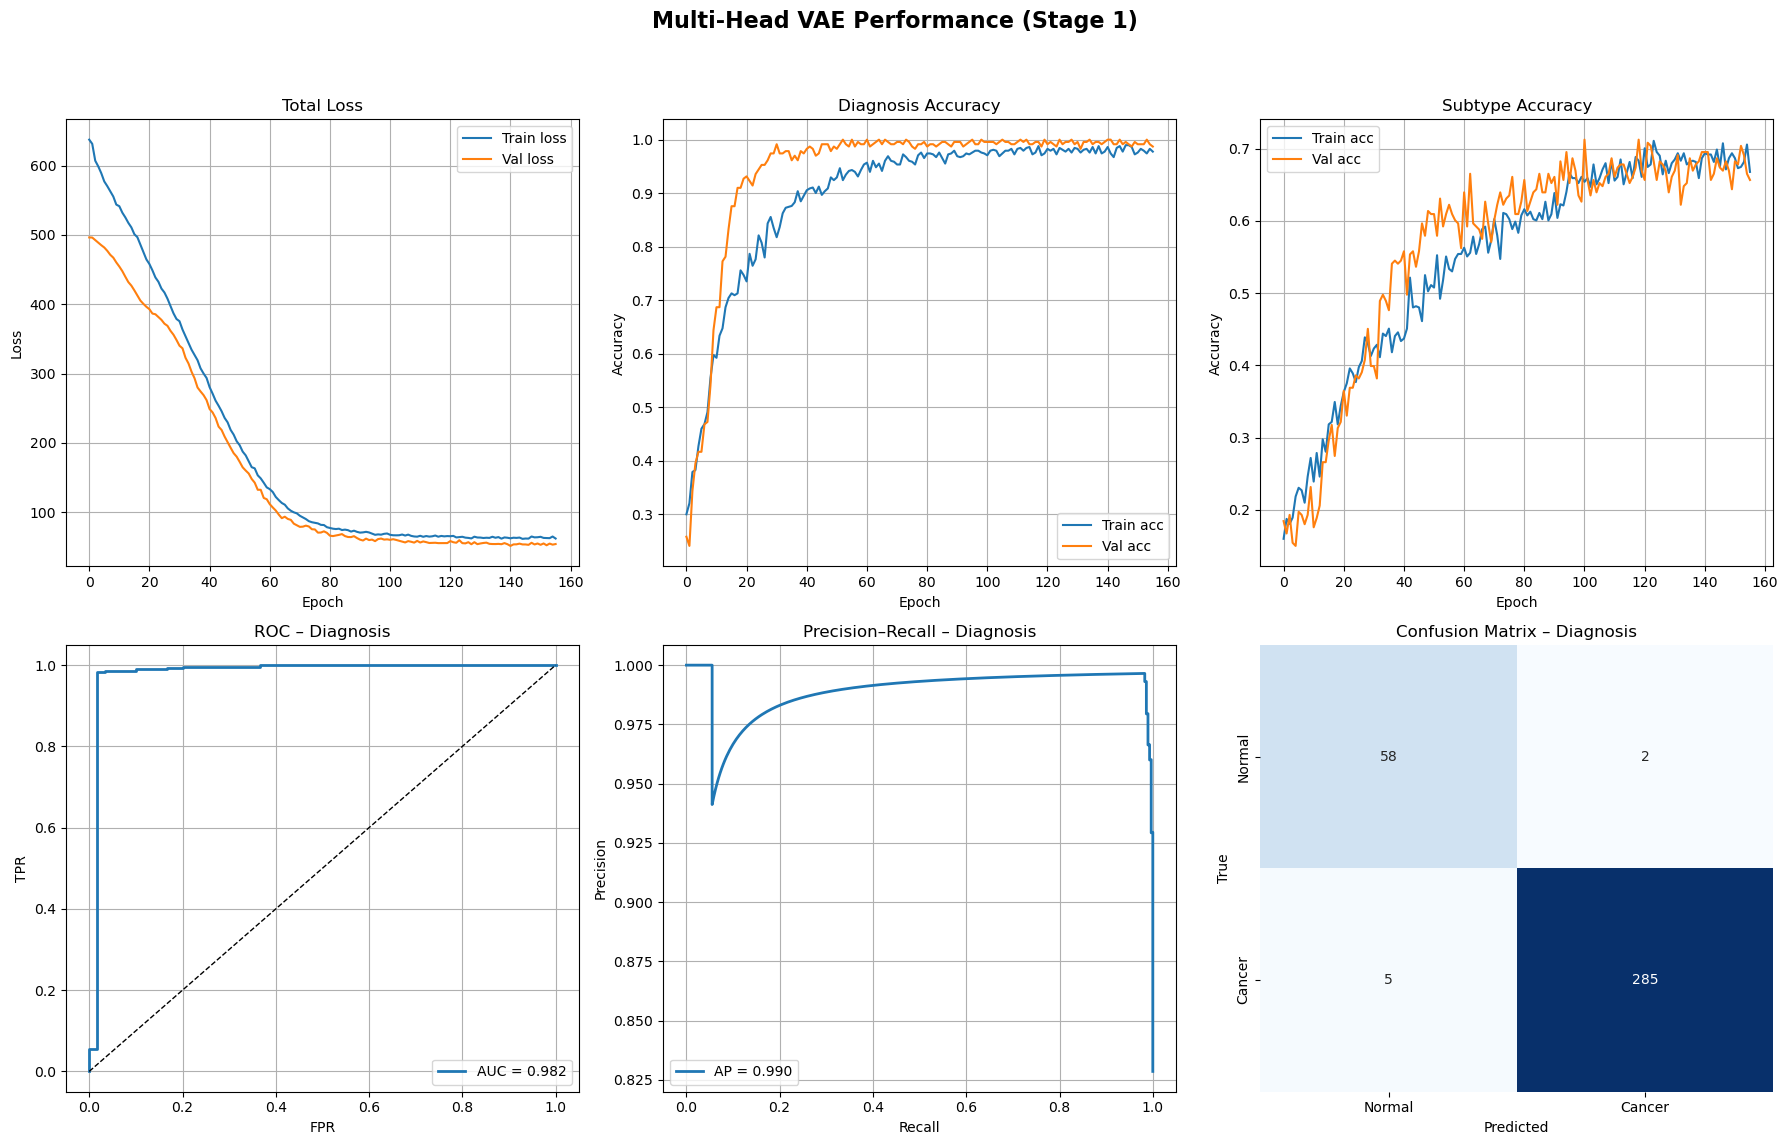

In [10]:
# Training curves and ROC/PR/confusion matrix (Stage 1)

fpr, tpr, _ = roc_curve(y_diag_test, preds["diagnosis_output"])
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_diag_test, preds["diagnosis_output"])
ap = average_precision_score(y_diag_test, preds["diagnosis_output"])
cm = confusion_matrix(y_diag_test, y_pred_diag)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.suptitle("Multi-Head VAE Performance (Stage 1)", fontsize=16, fontweight="bold")

# Loss
axes[0, 0].plot(history.history["loss"], label="Train loss")
axes[0, 0].plot(history.history["val_loss"], label="Val loss")
axes[0, 0].set_title("Total Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid()

# Diagnosis accuracy
axes[0, 1].plot(history.history["diagnosis_output_accuracy"], label="Train acc")
axes[0, 1].plot(history.history["val_diagnosis_output_accuracy"], label="Val acc")
axes[0, 1].set_title("Diagnosis Accuracy")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].legend()
axes[0, 1].grid()

# Subtype accuracy
axes[0, 2].plot(history.history["subtype_output_accuracy"], label="Train acc")
axes[0, 2].plot(history.history["val_subtype_output_accuracy"], label="Val acc")
axes[0, 2].set_title("Subtype Accuracy")
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].set_ylabel("Accuracy")
axes[0, 2].legend()
axes[0, 2].grid()

# ROC
axes[1, 0].plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
axes[1, 0].plot([0, 1], [0, 1], "k--", lw=1)
axes[1, 0].set_title("ROC – Diagnosis")
axes[1, 0].set_xlabel("FPR")
axes[1, 0].set_ylabel("TPR")
axes[1, 0].legend()
axes[1, 0].grid()

# PR curve
axes[1, 1].plot(recall, precision, lw=2, label=f"AP = {ap:.3f}")
axes[1, 1].set_title("Precision–Recall – Diagnosis")
axes[1, 1].set_xlabel("Recall")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()
axes[1, 1].grid()

# Confusion matrix
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Cancer"],
    yticklabels=["Normal", "Cancer"],
    ax=axes[1, 2],
    cbar=False,
)
axes[1, 2].set_title("Confusion Matrix – Diagnosis")
axes[1, 2].set_xlabel("Predicted")
axes[1, 2].set_ylabel("True")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
# Domain shift check #1 – classify GTEx vs TCGA normals

normals = all_samples[all_samples["type"] == "normal"].copy()
print("Normal samples by source:")
print(normals["source"].value_counts())

X_norm_raw = normals[all_genes].values.astype(np.float32)
X_norm_selected = X_norm_raw[:, top_k_indices]
X_norm_scaled   = scaler.transform(X_norm_selected)

source_labels = normals["source"].values
source_encoder = LabelEncoder()
y_source = source_encoder.fit_transform(source_labels)

print("\nSource classes (encoded):")
for cls, idx in zip(source_encoder.classes_, range(len(source_encoder.classes_))):
    print(f"  {cls}: {idx}")

X_norm_train, X_norm_test, y_source_train, y_source_test = train_test_split(
    X_norm_scaled,
    y_source,
    test_size=0.2,
    random_state=42,
    stratify=y_source,
)

print("\nNormals source split:")
print("  Train normals:", X_norm_train.shape[0])
print("  Test normals: ", X_norm_test.shape[0])

clf_source = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
)
clf_source.fit(X_norm_train, y_source_train)

y_source_pred  = clf_source.predict(X_norm_test)
y_source_proba = clf_source.predict_proba(X_norm_test)[:, 1]

print("\n--- Source Classification Report (GTEx vs TCGA normals) ---")
print(classification_report(y_source_test, y_source_pred, target_names=source_encoder.classes_))
print(f"AUC-ROC (source classifier): {roc_auc_score(y_source_test, y_source_proba):.4f}")

cm_source = confusion_matrix(y_source_test, y_source_pred)
print("\nConfusion matrix (rows=true, cols=pred):")
print(pd.DataFrame(
    cm_source,
    index=[f"true_{c}" for c in source_encoder.classes_],
    columns=[f"pred_{c}" for c in source_encoder.classes_],
))

Normal samples by source:
source
TCGA_normal    109
GTEx_normal     89
Name: count, dtype: int64

Source classes (encoded):
  GTEx_normal: 0
  TCGA_normal: 1

Normals source split:
  Train normals: 158
  Test normals:  40

--- Source Classification Report (GTEx vs TCGA normals) ---
              precision    recall  f1-score   support

 GTEx_normal       1.00      0.94      0.97        18
 TCGA_normal       0.96      1.00      0.98        22

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

AUC-ROC (source classifier): 1.0000

Confusion matrix (rows=true, cols=pred):
                  pred_GTEx_normal  pred_TCGA_normal
true_GTEx_normal                17                 1
true_TCGA_normal                 0                22


In [12]:
# Domain shift check #2 – VAE diagnosis errors among normals, by source (test set)

# idx_test came from the split in Cell 5
source_all = all_samples["source"].values
source_test = source_all[idx_test]

test_diag_df = pd.DataFrame({
    "true_diag": y_diag_test,
    "pred_diag": y_pred_diag,
    "source": source_test,
})

test_normals = test_diag_df[test_diag_df["true_diag"] == 0].copy()
print("Normal test samples by source:")
print(test_normals["source"].value_counts())

for src, group in test_normals.groupby("source"):
    cm = confusion_matrix(group["true_diag"], group["pred_diag"], labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    print(f"\nSource: {src}")
    print("  # Normal test samples:", len(group))
    print("  True normals correctly classified (TN):", tn)
    print("  Normals misclassified as cancer (FP):", fp)

Normal test samples by source:
source
TCGA_normal    34
GTEx_normal    26
Name: count, dtype: int64

Source: GTEx_normal
  # Normal test samples: 26
  True normals correctly classified (TN): 26
  Normals misclassified as cancer (FP): 0

Source: TCGA_normal
  # Normal test samples: 34
  True normals correctly classified (TN): 32
  Normals misclassified as cancer (FP): 2


In [13]:
# Baseline – Logistic regression (diagnosis)

X_baseline_train = np.vstack([X_train_scaled, X_val_scaled])
y_baseline_train = np.concatenate([y_diag_train, y_diag_val])

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
)

log_reg.fit(X_baseline_train, y_baseline_train)

y_log_pred  = log_reg.predict(X_test_scaled)
y_log_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\n--- Logistic Regression Baseline (Diagnosis) ---")
print(classification_report(y_diag_test, y_log_pred, target_names=["Normal", "Cancer"]))
print(f"AUC-ROC: {roc_auc_score(y_diag_test, y_log_proba):.4f}")

cm_log = confusion_matrix(y_diag_test, y_log_pred)
print("\nConfusion matrix (rows=true, cols=pred):")
print(pd.DataFrame(
    cm_log,
    index=["true_Normal", "true_Cancer"],
    columns=["pred_Normal", "pred_Cancer"],
))


--- Logistic Regression Baseline (Diagnosis) ---
              precision    recall  f1-score   support

      Normal       0.95      0.98      0.97        60
      Cancer       1.00      0.99      0.99       290

    accuracy                           0.99       350
   macro avg       0.97      0.99      0.98       350
weighted avg       0.99      0.99      0.99       350

AUC-ROC: 0.9994

Confusion matrix (rows=true, cols=pred):
             pred_Normal  pred_Cancer
true_Normal           59            1
true_Cancer            3          287


# Comparative Latent Space Visualization (VAE vs. PCA vs. AE)

This section demonstrates the effectiveness of the VAE in creating a distinct and separable latent space by comparing it to standard dimensionality reduction techniques like PCA and a Standard Autoencoder (AE)


--- Latent space comparison ---


2025-12-12 19:24:37.352863: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-12-12 19:24:37.353235: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

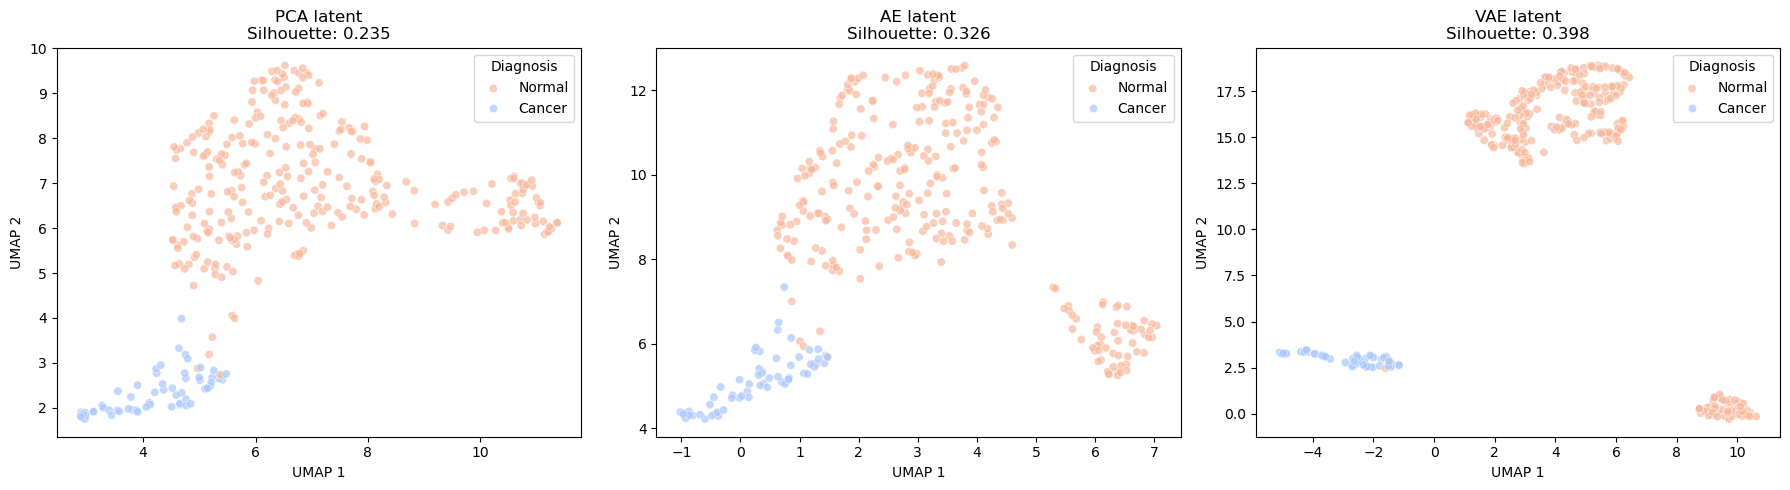


Silhouette scores:
  PCA: 0.2351
  AE:  0.3261
  VAE: 0.3982


In [14]:
# Latent space comparison – PCA vs AE vs VAE

print("\n--- Latent space comparison ---")

# VAE latent on test
encoder_out_test = vae.encoder_net.predict(X_test_scaled, verbose=0)
X_vae_latent = vae.z_mean(encoder_out_test).numpy()
sil_vae = silhouette_score(X_vae_latent, y_diag_test)

# PCA (fit on train, transform test)
pca_model = PCA(n_components=CONFIG["latent_dim"], random_state=42)
pca_model.fit(X_train_scaled)
X_pca_latent = pca_model.transform(X_test_scaled)
sil_pca = silhouette_score(X_pca_latent, y_diag_test)

# Standard autoencoder
input_dim = X_train_scaled.shape[1]
inputs_ae  = tf.keras.Input(shape=(input_dim,))
encoded    = layers.Dense(512, activation="relu")(inputs_ae)
latent_ae  = layers.Dense(CONFIG["latent_dim"], activation="linear", name="latent")(encoded)
decoded    = layers.Dense(512, activation="relu")(latent_ae)
outputs_ae = layers.Dense(input_dim, activation="sigmoid")(decoded)

ae = Model(inputs_ae, outputs_ae)
ae.compile(optimizer="adam", loss="mse")
ae.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=50,
    batch_size=CONFIG["batch_size"],
    verbose=0,
)

encoder_ae = Model(inputs_ae, latent_ae)
X_ae_latent = encoder_ae.predict(X_test_scaled, verbose=0)
sil_ae = silhouette_score(X_ae_latent, y_diag_test)

# UMAP projection
reducer = umap.UMAP(random_state=42)
umap_pca = reducer.fit_transform(X_pca_latent)
umap_ae  = reducer.fit_transform(X_ae_latent)
umap_vae = reducer.fit_transform(X_vae_latent)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x=umap_pca[:, 0], y=umap_pca[:, 1], hue=y_diag_test, palette="coolwarm", ax=axes[0], alpha=0.7)
axes[0].set_title(f"PCA latent\nSilhouette: {sil_pca:.3f}")
sns.scatterplot(x=umap_ae[:, 0], y=umap_ae[:, 1], hue=y_diag_test, palette="coolwarm", ax=axes[1], alpha=0.7)
axes[1].set_title(f"AE latent\nSilhouette: {sil_ae:.3f}")
sns.scatterplot(x=umap_vae[:, 0], y=umap_vae[:, 1], hue=y_diag_test, palette="coolwarm", ax=axes[2], alpha=0.7)
axes[2].set_title(f"VAE latent\nSilhouette: {sil_vae:.3f}")

for ax in axes:
    ax.legend(title="Diagnosis", labels=["Normal", "Cancer"])
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()

print("\nSilhouette scores:")
print(f"  PCA: {sil_pca:.4f}")
print(f"  AE:  {sil_ae:.4f}")
print(f"  VAE: {sil_vae:.4f}")

# Latent Variable Correlation Analysis (Interpretability)

This section correlates the latent dimensions with the input genes and the output diagnosis label to identify which biological features are driving each learned latent factor.


--- Latent Variable Correlation Analysis (Interpretability) ---
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Latent representation shape: (350, 64)


2025-12-12 19:26:13.185400: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-12-12 19:26:13.185768: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Top correlated genes for each latent dimension:
Latent_0: ['TGFBR2', 'TPM3', 'LHFP', 'AHNAK', 'KCTD12'] | Corr=[0.6383812564022583, 0.6308778762640883, 0.6232857435089795, 0.6217311590593761, 0.6152877241965283]
Latent_1: ['AURKAIP1', 'DNPH1', 'OXTR', 'TIMM13', 'MIF'] | Corr=[0.46692684756408614, 0.46621456813062556, 0.4456998429830112, 0.4446251827370481, 0.44003231401304865]
Latent_2: ['SMIM22', 'NME3', 'GATA3', 'MRPS34', 'STXBP2'] | Corr=[0.6883504788980873, 0.6658002689590358, 0.6609603422399715, 0.6346144143896508, 0.6305124701348017]
Latent_3: ['SOX10', 'CX3CL1', 'CMTM7', 'PRNP', 'KIT'] | Corr=[0.6895297358094052, 0.6527120641931203, 0.6449642607182742, 0.6427857153904726, 0.633884709864673]
Latent_4: ['HSPB6', 'FHL1', 'COX7A1', 'HSPB7', 'HADHB'] | Corr=[0.6503474496874183, 0.6302778800935815, 0.6284089515084744, 0.6262183371309867, 0.6176244730155931]
Latent_5: ['FOXA1', 'GATA3', 'SLC43A3', 'XBP1', 'SOX10'] | Corr=[0.8028584180701605, 0.7161853077795113, 0.6837954847482446, 0.6

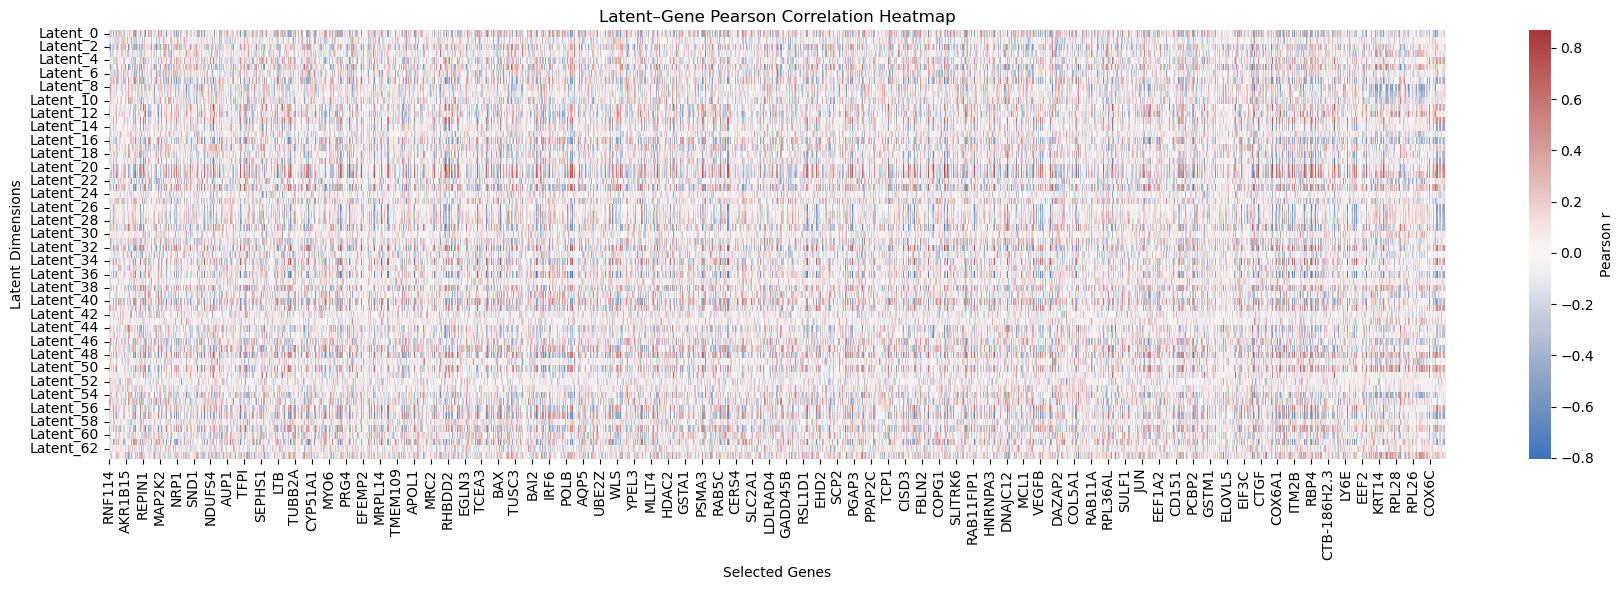

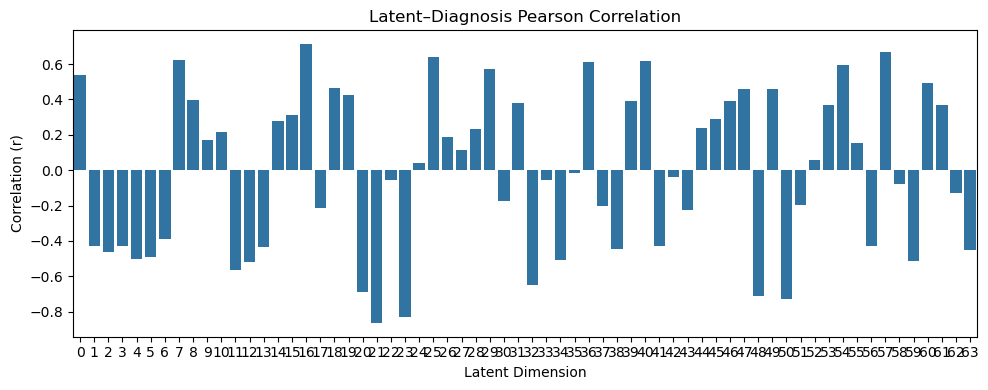


Latent dimensions strongly associated with diagnosis (|r| > 0.3):
Latent_0: r = 0.537
Latent_1: r = -0.427
Latent_2: r = -0.460
Latent_3: r = -0.430
Latent_4: r = -0.503
Latent_5: r = -0.489
Latent_6: r = -0.390
Latent_7: r = 0.621
Latent_8: r = 0.399
Latent_11: r = -0.565
Latent_12: r = -0.518
Latent_13: r = -0.436
Latent_15: r = 0.314
Latent_16: r = 0.712
Latent_18: r = 0.467
Latent_19: r = 0.426
Latent_20: r = -0.690
Latent_21: r = -0.863
Latent_23: r = -0.833
Latent_25: r = 0.642
Latent_29: r = 0.575
Latent_31: r = 0.380
Latent_32: r = -0.649
Latent_34: r = -0.507
Latent_36: r = 0.614
Latent_38: r = -0.446
Latent_39: r = 0.391
Latent_40: r = 0.619
Latent_41: r = -0.427
Latent_46: r = 0.392
Latent_47: r = 0.461
Latent_48: r = -0.709
Latent_49: r = 0.459
Latent_50: r = -0.728
Latent_53: r = 0.369
Latent_54: r = 0.592
Latent_56: r = -0.428
Latent_57: r = 0.669
Latent_59: r = -0.511
Latent_60: r = 0.491
Latent_61: r = 0.371
Latent_63: r = -0.450


In [15]:
## Latent Variable Correlation Analysis (Interpretability)

from scipy.stats import pearsonr

print("\n--- Latent Variable Correlation Analysis (Interpretability) ---")

# Get VAE Latent Space (z_mean)
z_test = vae.encoder_net.predict(X_test_scaled)
z_test = vae.z_mean(z_test).numpy()   # shape = (N, latent_dim)
latent_dim = z_test.shape[1]

print(f"Latent representation shape: {z_test.shape}")

# Calculate Pearson correlation (r) between each latent dimension and each gene
corr_matrix = np.zeros((latent_dim, X_train_scaled.shape[1]))

for i in range(latent_dim):
    for j in range(X_train_scaled.shape[1]):
        corr_matrix[i, j], _ = pearsonr(z_test[:, i], X_test_scaled[:, j])

corr_df = pd.DataFrame(
    corr_matrix,
    index=[f"Latent_{i}" for i in range(latent_dim)],
    columns=selected_gene_names
)

print("\nTop correlated genes for each latent dimension:")
for i in range(latent_dim):
    top_genes = corr_df.iloc[i].abs().sort_values(ascending=False).head(5)
    print(f"Latent_{i}: {list(top_genes.index)} | Corr={list(top_genes.values)}")

# ---- Heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(corr_df, cmap="vlag", center=0, cbar_kws={'label': 'Pearson r'})
plt.title("Latent–Gene Pearson Correlation Heatmap")
plt.xlabel("Selected Genes")
plt.ylabel("Latent Dimensions")
plt.tight_layout()
plt.show()

# --- Correlation with Diagnosis Label ---
y_corr = []
for i in range(latent_dim):
    c, _ = pearsonr(z_test[:, i], y_diag_test)
    y_corr.append(c)

plt.figure(figsize=(10, 4))
sns.barplot(x=list(range(latent_dim)), y=y_corr)
plt.title("Latent–Diagnosis Pearson Correlation")
plt.xlabel("Latent Dimension")
plt.ylabel("Correlation (r)")
plt.tight_layout()
plt.show()

print("\nLatent dimensions strongly associated with diagnosis (|r| > 0.3):")
for i, c in enumerate(y_corr):
    if abs(c) > 0.3:
        print(f"Latent_{i}: r = {c:.3f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


2025-12-12 19:32:27.842424: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-12-12 19:32:27.842797: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

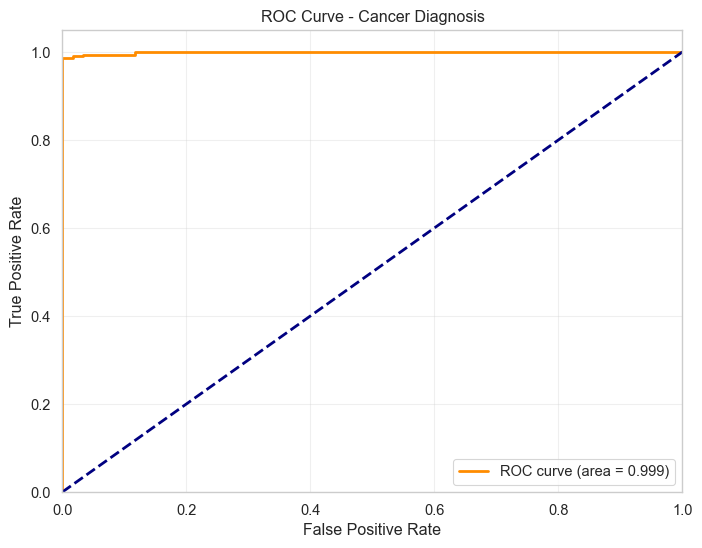

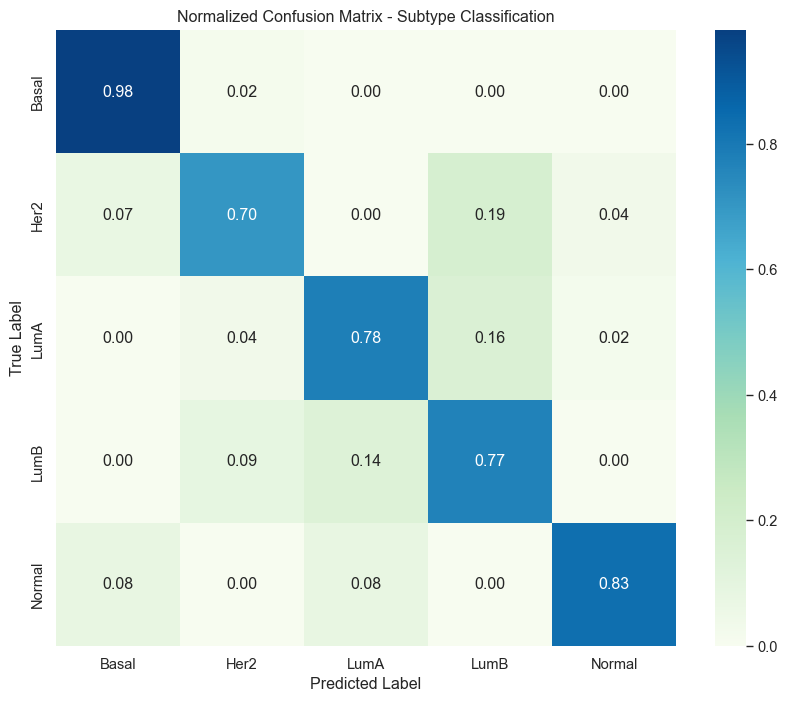

Generating Latent Space UMAP...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


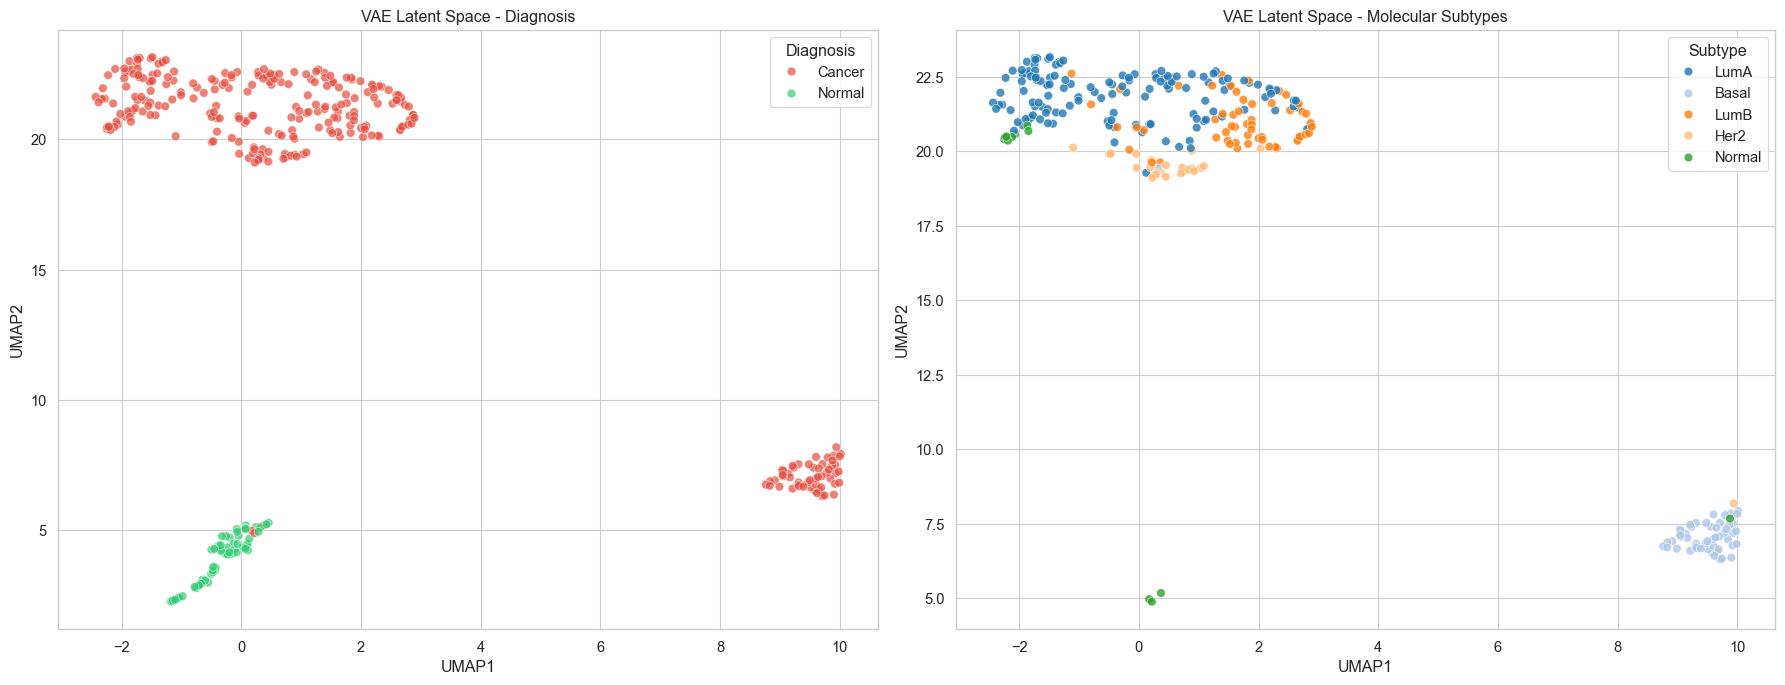

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np
import umap

sns.set(style="whitegrid", context="paper", font_scale=1.2)

def plot_advanced_results(model, X_test, y_diag_test, y_sub_test, mask_test, subtype_encoder):
    

    preds = model.predict(X_test)
    y_diag_pred_prob = preds['diagnosis_output'].flatten()
    
    # --- ROC Curve for Diagnosis ---
    fpr, tpr, _ = roc_curve(y_diag_test, y_diag_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Cancer Diagnosis')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig("results/roc_diagnosis.png", dpi=300)
    plt.show()

    # --- Confusion Matrix for Subtypes ---
    valid_idx = np.where(mask_test == 1)[0]
    
    if len(valid_idx) > 0:
        y_sub_true = y_sub_test[valid_idx]
        y_sub_pred_prob = preds['subtype_output'][valid_idx]
        y_sub_pred = np.argmax(y_sub_pred_prob, axis=1)
        
        classes = [c for c in subtype_encoder.classes_ if c != 'NA']
        
        
        cm = confusion_matrix(y_sub_true, y_sub_pred, normalize='true')
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='GnBu', xticklabels=classes, yticklabels=classes)
        plt.title('Normalized Confusion Matrix - Subtype Classification')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig("results/cm_subtype_normalized.png", dpi=300)
        plt.show()
    else:
        print("No labeled tumor samples in test set for confusion matrix.")

    # --- Latent Space Visualization (UMAP) ---
    print("Generating Latent Space UMAP...")

    h = model.encoder_net.predict(X_test)
    z_mean = model.z_mean(h).numpy()
    
    reducer = umap.UMAP(random_state=42, n_neighbors=30, min_dist=0.1)
    embedding = reducer.fit_transform(z_mean)
    
    df_umap = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    df_umap['Diagnosis'] = ['Cancer' if x==1 else 'Normal' for x in y_diag_test]
    
    subtypes_decoded = subtype_encoder.inverse_transform(y_sub_test)
    df_umap['Subtype'] = subtypes_decoded

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot A
    sns.scatterplot(ax=axes[0], x='UMAP1', y='UMAP2', hue='Diagnosis', data=df_umap, 
                    palette={'Cancer': '#E74C3C', 'Normal': '#2ECC71'}, alpha=0.7, s=40)
    axes[0].set_title('VAE Latent Space - Diagnosis')
    
    # Plot B
    df_umap_sub = df_umap[df_umap['Subtype'] != 'NA']
    if not df_umap_sub.empty:
        sns.scatterplot(ax=axes[1], x='UMAP1', y='UMAP2', hue='Subtype', data=df_umap_sub, 
                        palette='tab20', alpha=0.8, s=40)
        axes[1].set_title('VAE Latent Space - Molecular Subtypes')
    else:
        axes[1].text(0.5, 0.5, 'No Subtype Labels', ha='center')
    
    plt.tight_layout()
    plt.savefig("results/latent_space_analysis.png", dpi=300)
    plt.show()

plot_advanced_results(vae, X_test_scaled, y_diag_test, y_sub_test, mask_test, subtype_encoder)

--- Analyzing Data Transformation Pipeline ---
Extracting latent space representation...
Computing UMAP for Input Space (this may take a moment)...


2025-12-12 19:32:47.575478: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-12-12 19:32:47.575923: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Computing UMAP for Latent Space...


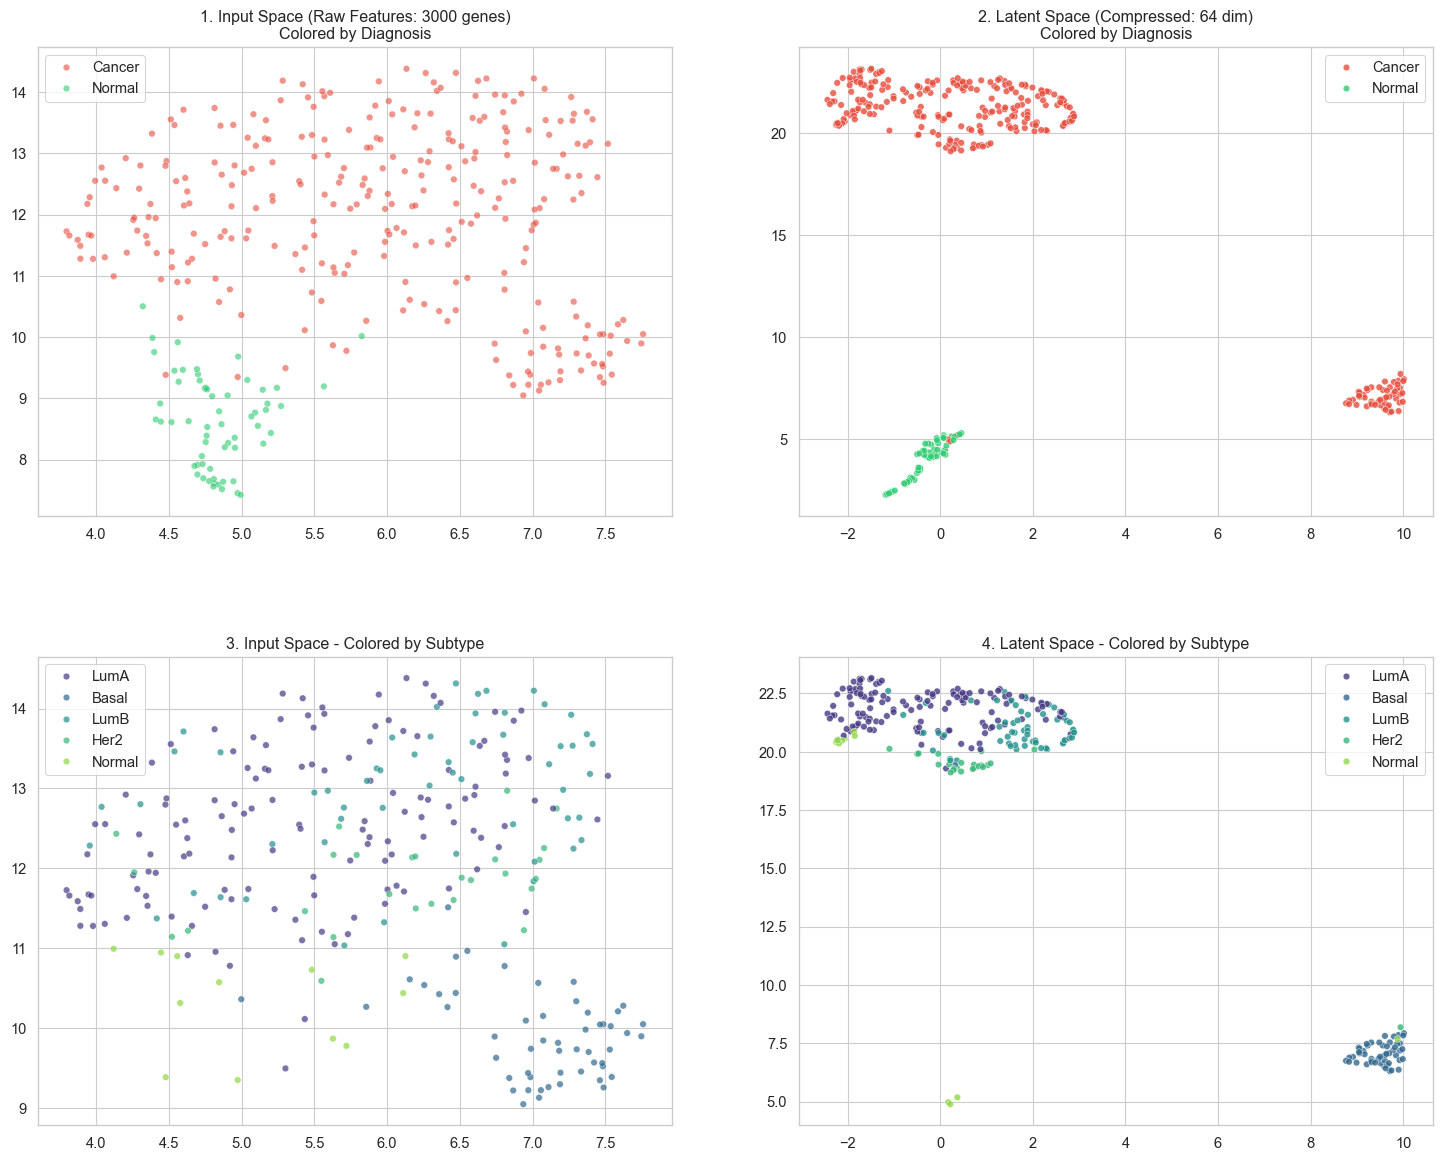


--- Checking Distribution Normality ---


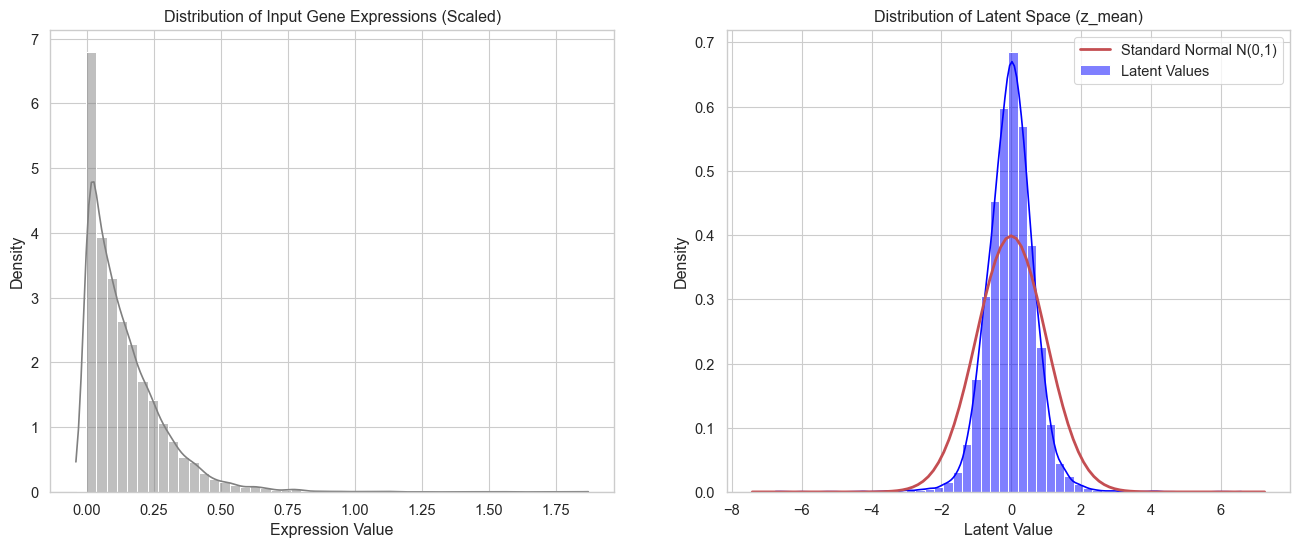

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import numpy as np
from scipy.stats import norm

def analyze_data_transformation(model, X_input, y_diagnosis, y_subtype, subtype_encoder):
    print("--- Analyzing Data Transformation Pipeline ---")
    
    # (Latent Representation)
    print("Extracting latent space representation...")
    
    encoder_output = model.encoder_net.predict(X_input, verbose=0)
    z_mean = model.z_mean(encoder_output)
    z_mean_np = z_mean.numpy() if hasattr(z_mean, 'numpy') else np.array(z_mean)
    
    print("Computing UMAP for Input Space (this may take a moment)...")
    reducer = umap.UMAP(random_state=42, n_neighbors=30, min_dist=0.1)
    embedding_input = reducer.fit_transform(X_input)
    
    print("Computing UMAP for Latent Space...")
    embedding_latent = reducer.fit_transform(z_mean_np)
    
    diag_labels = ['Cancer' if x==1 else 'Normal' for x in y_diagnosis]
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    
    # A. Input Space - Diagnosis
    sns.scatterplot(ax=axes[0, 0], x=embedding_input[:, 0], y=embedding_input[:, 1], 
                    hue=diag_labels, palette={'Cancer': '#E74C3C', 'Normal': '#2ECC71'}, alpha=0.6)
    axes[0, 0].set_title(f'1. Input Space (Raw Features: {X_input.shape[1]} genes)\nColored by Diagnosis')
    
    # B. Latent Space - Diagnosis
    sns.scatterplot(ax=axes[0, 1], x=embedding_latent[:, 0], y=embedding_latent[:, 1], 
                    hue=diag_labels, palette={'Cancer': '#E74C3C', 'Normal': '#2ECC71'}, alpha=0.8)
    axes[0, 1].set_title(f'2. Latent Space (Compressed: {z_mean_np.shape[1]} dim)\nColored by Diagnosis')
    
    # C. Input Space - Subtype
    mask_valid = y_subtype != 4 
    valid_indices = np.where(mask_valid)[0]
    
    if len(valid_indices) > 0:
        subtypes_decoded = subtype_encoder.inverse_transform(y_subtype[valid_indices])
        sns.scatterplot(ax=axes[1, 0], x=embedding_input[valid_indices, 0], y=embedding_input[valid_indices, 1], 
                        hue=subtypes_decoded, palette='viridis', alpha=0.7, legend='full')
    axes[1, 0].set_title('3. Input Space - Colored by Subtype')
    
    # D. Latent Space - Subtype
    if len(valid_indices) > 0:
        sns.scatterplot(ax=axes[1, 1], x=embedding_latent[valid_indices, 0], y=embedding_latent[valid_indices, 1], 
                        hue=subtypes_decoded, palette='viridis', alpha=0.8, legend='full')
    axes[1, 1].set_title('4. Latent Space - Colored by Subtype')

    plt.savefig("results/comparison_input_vs_latent.png", dpi=300)
    plt.show()

    # --- (Distribution Check) ---
    print("\n--- Checking Distribution Normality ---")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sample_size = 10000
    
    # (Input Distribution)
    input_sample = X_input.flatten()
    if len(input_sample) > sample_size:
        input_sample = np.random.choice(input_sample, sample_size, replace=False)
        
    sns.histplot(input_sample, kde=True, ax=axes[0], color='gray', stat="density", bins=50)
    axes[0].set_title("Distribution of Input Gene Expressions (Scaled)")
    axes[0].set_xlabel("Expression Value")
    
    # (Latent Distribution)
    latent_sample = z_mean_np.flatten()
    if len(latent_sample) > sample_size:
        latent_sample = np.random.choice(latent_sample, sample_size, replace=False)
        
    sns.histplot(latent_sample, kde=True, ax=axes[1], color='blue', stat="density", bins=50, label='Latent Values')
    
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, 0, 1)
    axes[1].plot(x, p, 'r', linewidth=2, label='Standard Normal N(0,1)')
    
    axes[1].set_title("Distribution of Latent Space (z_mean)")
    axes[1].set_xlabel("Latent Value")
    axes[1].legend()
    
    plt.savefig("results/distribution_check.png", dpi=300)
    plt.show()

analyze_data_transformation(vae, X_test_scaled, y_diag_test, y_sub_test, subtype_encoder)

# Robust Feature Selection (SHAP Stability Analysis)

To find the most reliable and influential genes for the Diagnosis task, this section performs stability analysis by retraining the model multiple times and using SHAP values to rank gene importance in each run.

In [ ]:
##  Robust Feature Selection (SHAP Stability Analysis)

# --- Configuration for Stability ---
NUM_RUNS = 10   # Number of times to retrain the model
TOP_K = 20      # Number of top genes to select in each run
STABILITY_EPOCHS = 50 # Reduced epochs for faster stability check

top_genes_history = []
print(f"--- Starting Stability Selection: {NUM_RUNS} Runs ---")

for run in range(NUM_RUNS):
    # --- A. Reset Model and Compile ---
    tf.keras.backend.clear_session()
    tf.random.set_seed(42 + run) # Use a different seed for each run
    np.random.seed(42 + run)

    temp_vae = MultiHeadVAE(
        original_dim=X_train_scaled.shape[1],
        latent_dim=CONFIG['latent_dim'],
        num_subtype_classes=len(subtype_encoder.classes_),
        beta=CONFIG['beta_kl']
    )
    
    # Recompile with the same settings
    temp_vae.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss={'diagnosis_output': 'binary_crossentropy', 'subtype_output': 'sparse_categorical_crossentropy', 'reconstruction_output': None },
        loss_weights={'diagnosis_output': CONFIG['weight_diag'], 'subtype_output': CONFIG['weight_sub'], 'reconstruction_output': 0.0}
    )
    
    # --- B. Quick Training ---
    # sample_weights_dict is reused from section 7
    temp_vae.fit(
        X_train_scaled,
        {'diagnosis_output': y_diag_train, 'subtype_output': y_sub_train, 'reconstruction_output': X_train_scaled},
        sample_weight=sample_weights_dict,
        epochs=STABILITY_EPOCHS, 
        batch_size=CONFIG['batch_size'],
        verbose=0 
    )
    
    # --- C. SHAP Calculation ---
    def predict_wrapper(data):
        # Wrapper function to return only the diagnosis probability
        return temp_vae.predict(data, verbose=0)['diagnosis_output'].flatten()
    
    # Use 30 background samples and 30 test samples for efficiency
    background = shap.kmeans(X_train_scaled, 30)
    explainer = shap.KernelExplainer(predict_wrapper, background)
    
    X_test_sample = X_test_scaled[:30]
    shap_values = explainer.shap_values(X_test_sample, silent=True)
    
    if isinstance(shap_values, list): shap_values = shap_values[0]
    
    # --- D. Extract TOP K Genes ---
    mean_shap = np.abs(shap_values).mean(axis=0)
    top_indices = np.argsort(mean_shap)[-TOP_K:]
    current_top_genes = [selected_gene_names[i] for i in top_indices]
    
    top_genes_history.extend(current_top_genes)
    print(f"   Run {run + 1}: Top 3 genes = {current_top_genes[-3:]}")

# --- 2. Analysis and Reporting ---
print("\n========================================")
print("   STABILITY SELECTION FINAL RESULTS")
print("========================================")
gene_counts = Counter(top_genes_history)
threshold = NUM_RUNS / 2

# Report Robust Genes
robust_genes = [gene for gene, count in gene_counts.items() if count >= threshold]
print(f"Minimum occurrence for 'Robust' gene: {int(threshold)} runs")
print(f"Number of robust genes (appeared >{threshold} times): {len(robust_genes)}")

# Report Final Top 20 Panel
print("\n🥇 Top 20 Most Frequent Genes (Final Panel):")
final_top_20_panel = []
for gene, count in gene_counts.most_common(20):
    final_top_20_panel.append(gene)
    print(f"   {gene}: appeared in {count}/{NUM_RUNS} runs")

print("\n\nFINAL ROBUST GENE PANEL:")
print(final_top_20_panel)

In [18]:
# Logestic Regression L1 Gene Panel instead of SHAP

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

TOP_K = 20  

print("\n--- L1 Logistic Regression for gene panel selection ---")

X_l1 = np.vstack([X_train_scaled, X_val_scaled])
y_l1 = np.concatenate([y_diag_train, y_diag_val])

print("X_l1 shape:", X_l1.shape)
print("y_l1 shape:", y_l1.shape)
print("Class balance (train+val):")
unique, counts = np.unique(y_l1, return_counts=True)
for u, c in zip(unique, counts):
    lab = "Normal" if u == 0 else "Cancer"
    print(f"  {lab:7s}: {c}")

logit_l1 = LogisticRegression(
    penalty="l1",
    solver="saga",          
    C=0.1,                 
    max_iter=5000,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

print("\nFitting L1-regularized Logistic Regression (this selects important genes)...")
logit_l1.fit(X_l1, y_l1)

coef = logit_l1.coef_.ravel()        
abs_coef = np.abs(coef)
nonzero = np.sum(coef != 0)

print(f"\nTotal features: {len(coef)}")
print(f"Non-zero coefficients after L1: {nonzero}")

# Select TOP_K Genes based on coefficient
top_indices = np.argsort(abs_coef)[-TOP_K:][::-1]  

final_top_20_panel = [selected_gene_names[i] for i in top_indices]

print(f"\nTop {TOP_K} genes by |L1 coefficient|:")
for rank, idx in enumerate(top_indices, 1):
    gene = selected_gene_names[idx]
    print(f"{rank:2d}. {gene:15s}  coef={coef[idx]: .4f}")

print("\nFINAL L1-BASED GENE PANEL:")
print(final_top_20_panel)

y_test_pred  = logit_l1.predict(X_test_scaled)
y_test_proba = logit_l1.predict_proba(X_test_scaled)[:, 1]

print("\n--- L1 Logistic Regression performance on TEST (using all 3000 genes) ---")
print(classification_report(y_diag_test, y_test_pred, target_names=["Normal", "Cancer"]))
print("AUC-ROC:", roc_auc_score(y_diag_test, y_test_proba))


--- L1 Logistic Regression for gene panel selection ---
X_l1 shape: (814, 3000)
y_l1 shape: (814,)
Class balance (train+val):
  Normal : 138
  Cancer : 676

Fitting L1-regularized Logistic Regression (this selects important genes)...

Total features: 3000
Non-zero coefficients after L1: 12

Top 20 genes by |L1 coefficient|:
 1. DST              coef=-3.7996
 2. ADH5             coef=-2.4852
 3. MYLK             coef=-2.3651
 4. TENC1            coef=-1.4857
 5. EPAS1            coef=-1.4230
 6. METTL7A          coef=-0.9396
 7. CXCL12           coef=-0.7341
 8. NDRG2            coef=-0.5949
 9. CALCOCO1         coef=-0.3693
10. SPRY1            coef=-0.3479
11. ITGA7            coef=-0.1509
12. ALDH1A1          coef=-0.0219
13. LLGL2            coef= 0.0000
14. MUSTN1           coef= 0.0000
15. SLC39A4          coef= 0.0000
16. MARCO            coef= 0.0000
17. SAMD4B           coef= 0.0000
18. TOMM5            coef= 0.0000
19. ANXA7            coef= 0.0000
20. MAPK3            coef= 

In [19]:
# Train final VAE on 20-gene panel

print("\n--- Final VAE on robust 20-gene panel ---")

if "final_top_20_panel" not in globals():
    raise RuntimeError("final_top_20_panel not defined. Run SHAP stability cell first.")

final_genes_panel = list(final_top_20_panel)
final_indices = [selected_gene_names.index(gene) for gene in final_genes_panel]

X_train_final = X_train_scaled[:, final_indices]
X_val_final   = X_val_scaled[:, final_indices]
X_test_final  = X_test_scaled[:, final_indices]

print(f"Final feature dimension: {X_train_final.shape[1]} genes")
print("Final gene panel:", final_genes_panel)

final_vae = MultiHeadVAE(
    original_dim=X_train_final.shape[1],
    latent_dim=CONFIG["latent_dim"],
    num_subtype_classes=len(subtype_encoder.classes_),
    beta=CONFIG["beta_kl"],
)

final_vae.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG["learning_rate"], clipnorm=1.0),
    loss={
        "diagnosis_output": "binary_crossentropy",
        "subtype_output": "sparse_categorical_crossentropy",
        "reconstruction_output": None,
    },
    loss_weights={
        "diagnosis_output": CONFIG["weight_diag"],
        "subtype_output": CONFIG["weight_sub"],
        "reconstruction_output": 0.01,
    },
    metrics={
        "diagnosis_output": "accuracy",
        "subtype_output": "accuracy",
    },
)

history_final = final_vae.fit(
    X_train_final,
    {
        "diagnosis_output": y_diag_train,
        "subtype_output": y_sub_train,
        "reconstruction_output": X_train_final,
    },
    sample_weight=sample_weights_train,
    validation_data=(
        X_val_final,
        {
            "diagnosis_output": y_diag_val,
            "subtype_output": y_sub_val,
            "reconstruction_output": X_val_final,
        },
        sample_weights_val,
    ),
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor="val_loss")
    ],
    verbose=1,
)


--- Final VAE on robust 20-gene panel ---
Final feature dimension: 20 genes
Final gene panel: ['DST', 'ADH5', 'MYLK', 'TENC1', 'EPAS1', 'METTL7A', 'CXCL12', 'NDRG2', 'CALCOCO1', 'SPRY1', 'ITGA7', 'ALDH1A1', 'LLGL2', 'MUSTN1', 'SLC39A4', 'MARCO', 'SAMD4B', 'TOMM5', 'ANXA7', 'MAPK3']
Epoch 1/200


2025-12-12 19:35:40.502337: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_20}}
2025-12-12 19:35:40.502774: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - diagnosis_output_accuracy: 0.2909 - diagnosis_output_loss: 2.1834 - loss: 281.9487 - subtype_output_accuracy: 0.1394 - subtype_output_loss: 2.0192 - val_diagnosis_output_accuracy: 0.2961 - val_diagnosis_output_loss: 1.2115 - val_loss: 44.1351 - val_subtype_output_accuracy: 0.0815 - val_subtype_output_loss: 1.5841
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - diagnosis_output_accuracy: 0.3115 - diagnosis_output_loss: 2.0077 - loss: 181.6202 - subtype_output_accuracy: 0.1670 - subtype_output_loss: 1.8729 - val_diagnosis_output_accuracy: 0.2532 - val_diagnosis_output_loss: 1.2224 - val_loss: 43.7747 - val_subtype_output_accuracy: 0.0901 - val_subtype_output_loss: 1.5465
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - diagnosis_output_accuracy: 0.3649 - diagnosis_output_loss: 2.0871 - loss: 193.7648 - subtype_output_accuracy: 0.1945 - subtype_output_loss: 1.9533 - val_diagnosis_output_accuracy: 0.2661 - val_diagnosis_output_loss: 1.202


--- 3. Generating Publication-Quality Figures ---


2025-12-12 19:35:55.693284: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-12-12 19:35:55.693675: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

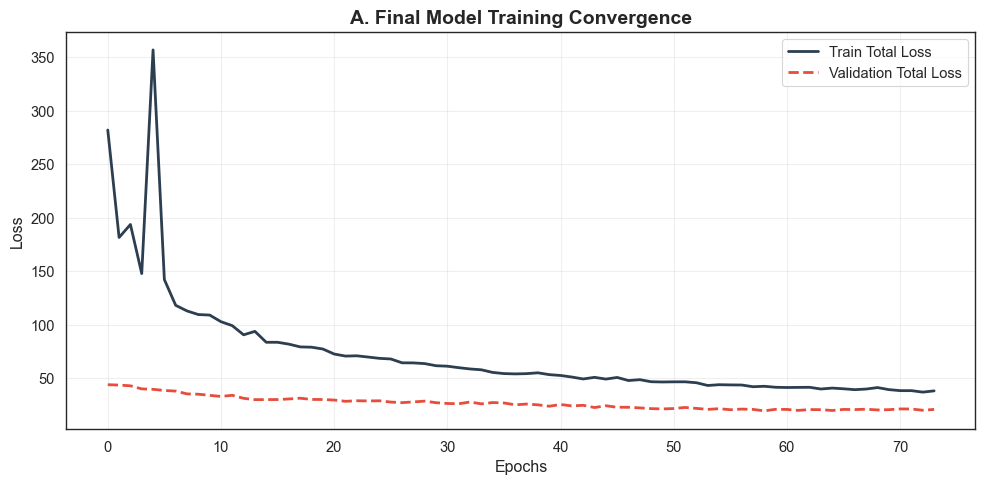

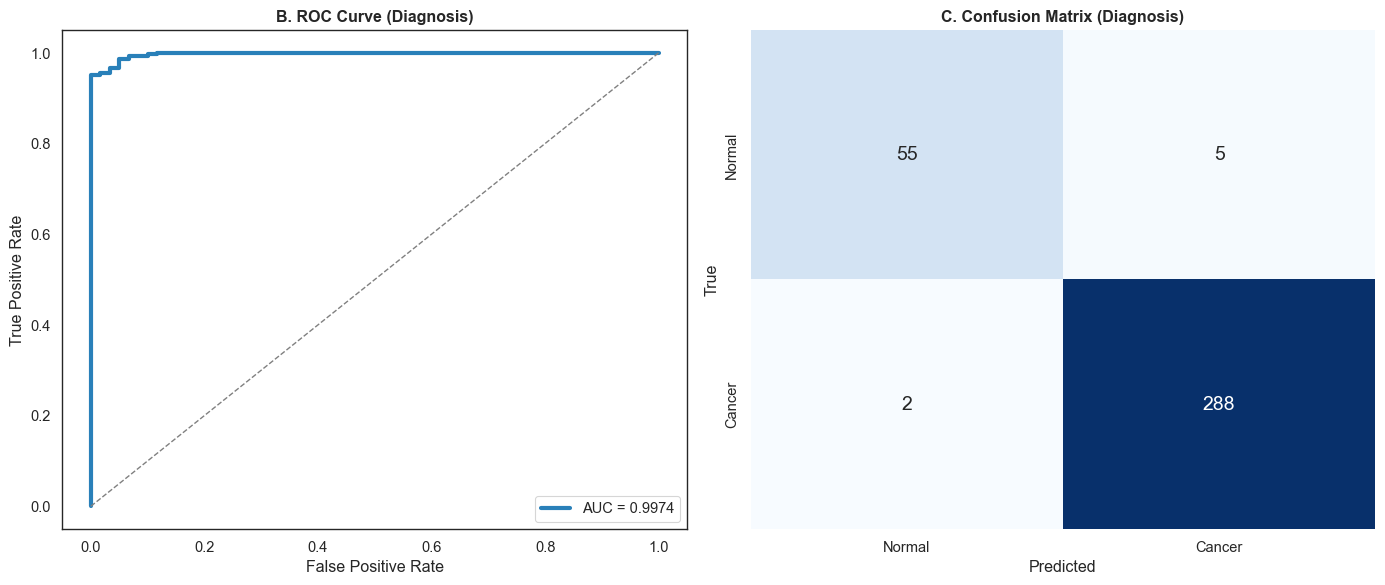

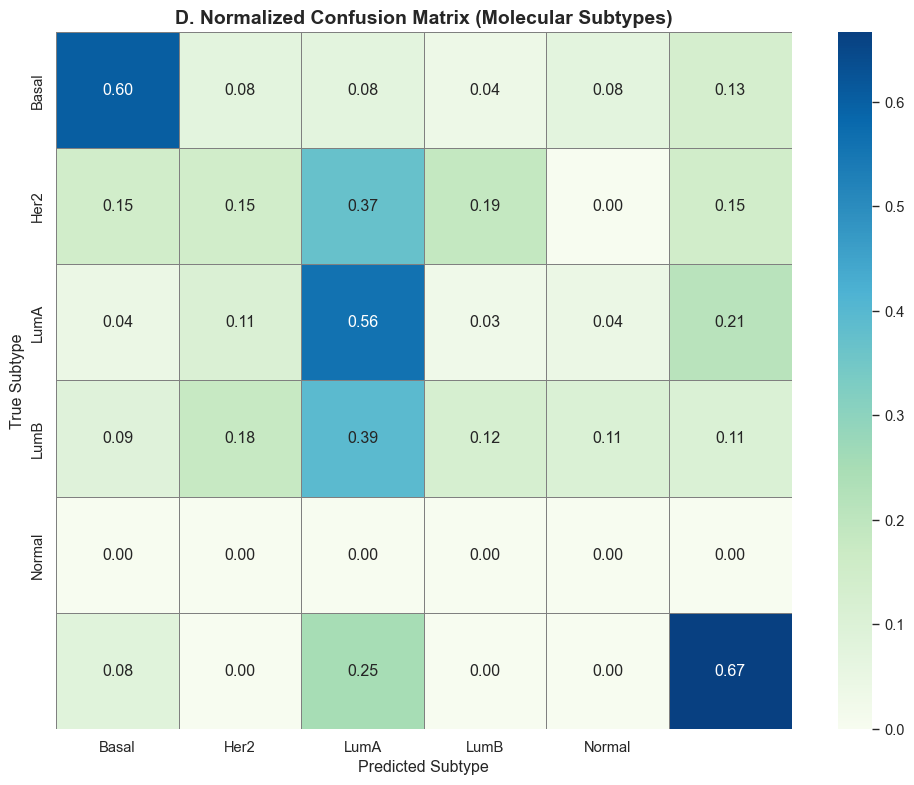


Computing UMAP for Latent Space...


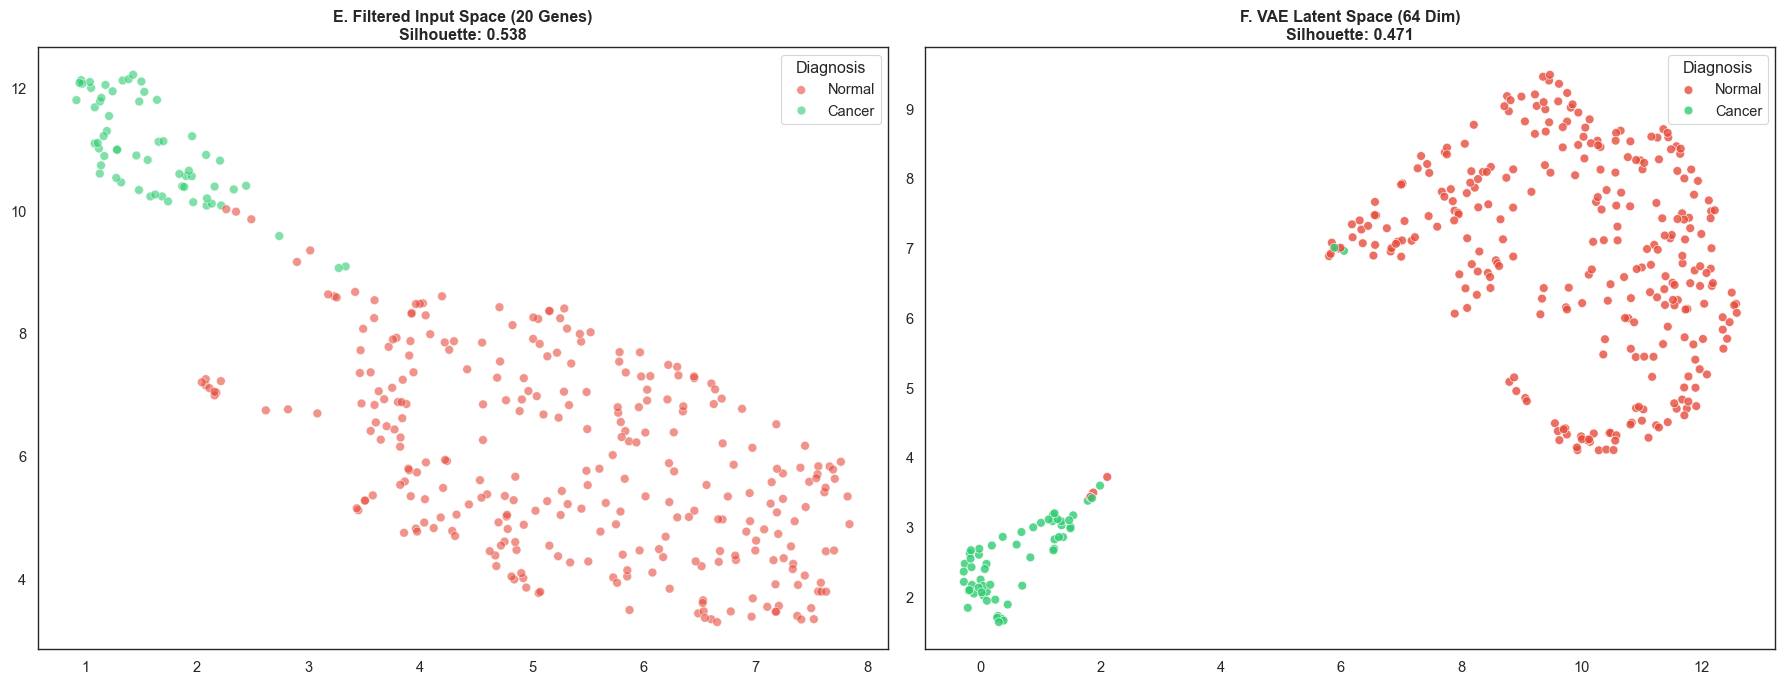

Silhouette Score (Latent) vs Raw: 0.471 vs 0.538

Generating Reconstruction Quality Plot...


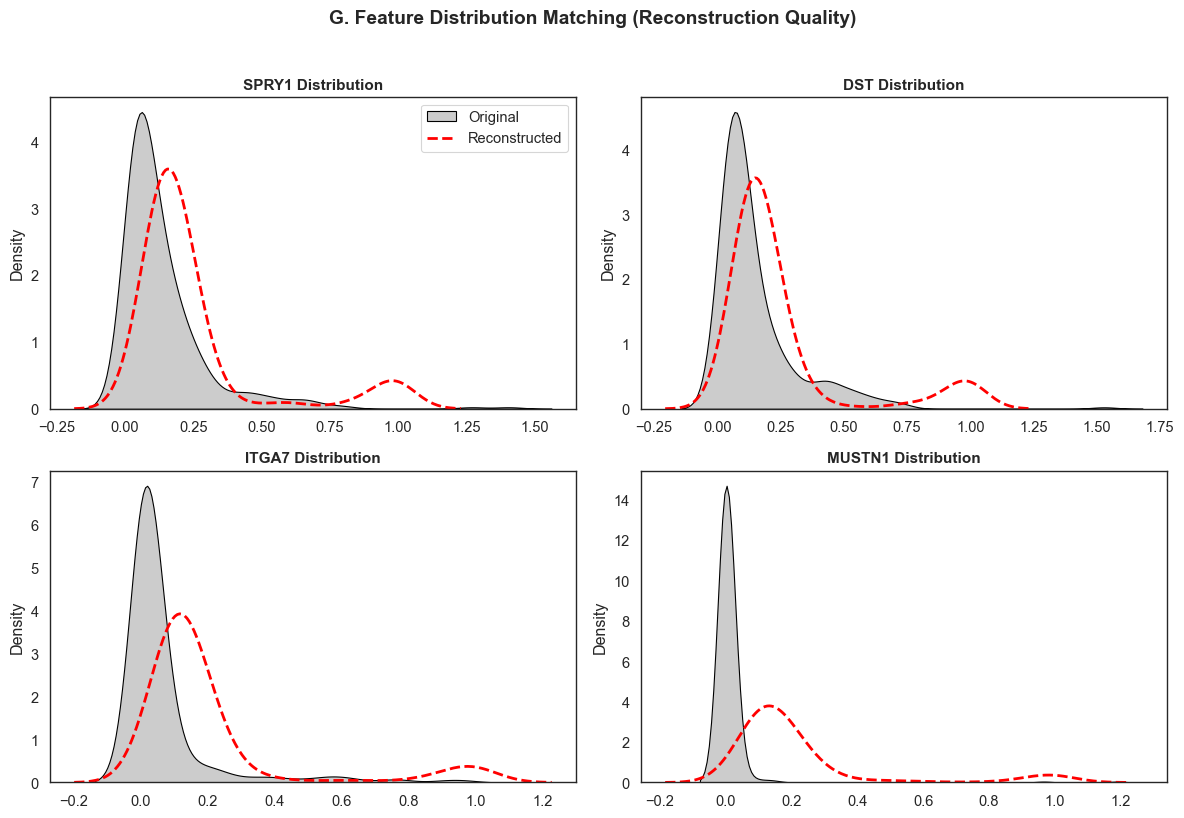

In [20]:
## Publication-Quality Visualizations (Figures 1-5)

import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import roc_curve, auc, confusion_matrix
import umap.umap_ as umap

print("\n--- 3. Generating Publication-Quality Figures ---")

# Setup
sns.set_theme(style="white", context="paper", font_scale=1.2)
if not os.path.exists('paper_figures_final'): os.makedirs('paper_figures_final')

# Predictions and Latent Space Extraction
preds_final = final_vae.predict(X_test_final, verbose=0)
y_pred_diag_prob = preds_final['diagnosis_output'].flatten()
y_pred_diag = (y_pred_diag_prob > 0.5).astype(int)
X_recon_final = preds_final['reconstruction_output']

encoder_out = final_vae.encoder_net.predict(X_test_final, verbose=0)
z_mean = final_vae.z_mean(encoder_out).numpy()

# FIG 1: TRAINING STABILITY (Loss Curves)
plt.figure(figsize=(10, 5))
plt.plot(history_final.history['loss'], label='Train Total Loss', linewidth=2, color='#2c3e50')
plt.plot(history_final.history['val_loss'], label='Validation Total Loss', linewidth=2, linestyle='--', color='#e74c3c')
plt.title('A. Final Model Training Convergence', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# FIG 2: DIAGNOSIS PERFORMANCE (ROC Curve + Confusion Matrix)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_diag_test, y_pred_diag_prob)
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, color='#2980b9', lw=3, label=f'AUC = {roc_auc:.4f}')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[0].set_title('B. ROC Curve (Diagnosis)', fontweight='bold')
axes[0].set_xlabel('False Positive Rate'); axes[0].set_ylabel('True Positive Rate');
axes[0].legend(loc="lower right")

# Diagnosis Confusion Matrix
cm_diag = confusion_matrix(y_diag_test, y_pred_diag)
sns.heatmap(cm_diag, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False,
            xticklabels=['Normal', 'Cancer'], yticklabels=['Normal', 'Cancer'], annot_kws={"size": 14})
axes[1].set_title('C. Confusion Matrix (Diagnosis)', fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True');

plt.tight_layout()
plt.show()

# FIG 3: SUBTYPE CLASSIFICATION (Normalized Confusion Matrix)
valid_idx = np.where(mask_test == 1)[0]
if len(valid_idx) > 0:
    y_true_sub = y_sub_test[valid_idx]
    y_pred_sub = np.argmax(preds_final['subtype_output'][valid_idx], axis=1)
    
    # Get classes excluding 'NA'
    classes = [c for c in subtype_encoder.classes_ if c != 'NA'] 
    cm_sub = confusion_matrix(y_true_sub, y_pred_sub, normalize='true') # Normalized
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_sub, annot=True, fmt='.2f', cmap='GnBu', 
                xticklabels=classes, yticklabels=classes, linewidths=0.5, linecolor='gray')
    plt.title('D. Normalized Confusion Matrix (Molecular Subtypes)', fontsize=14, fontweight='bold')
    plt.ylabel('True Subtype')
    plt.xlabel('Predicted Subtype')
    plt.tight_layout()
    plt.show()

# FIG 4: LATENT SPACE VISUALIZATION (UMAP Analysis) 
print("\nComputing UMAP for Latent Space...")
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1) 
    
# UMAP on Filtered Raw Data (20 Genes)
umap_raw = reducer.fit_transform(X_test_final)
# UMAP on Latent Space (64 Dim)
umap_latent = reducer.fit_transform(z_mean)

sil_raw = silhouette_score(X_test_final, y_diag_test)
sil_latent = silhouette_score(z_mean, y_diag_test)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot E: Raw Data (Filtered)
sns.scatterplot(x=umap_raw[:,0], y=umap_raw[:,1], hue=y_diag_test, 
                   palette={0:'#2ECC71', 1:'#E74C3C'}, alpha=0.6, s=40, ax=axes[0])
axes[0].set_title(f'E. Filtered Input Space ({len(final_genes_panel)} Genes)\nSilhouette: {sil_raw:.3f}', fontweight='bold')
axes[0].legend(title='Diagnosis', labels=['Normal', 'Cancer'])

# Plot F: Latent Space
sns.scatterplot(x=umap_latent[:,0], y=umap_latent[:,1], hue=y_diag_test, 
                   palette={0:'#2ECC71', 1:'#E74C3C'}, alpha=0.8, s=40, ax=axes[1])
axes[1].set_title(f'F. VAE Latent Space ({CONFIG["latent_dim"]} Dim)\nSilhouette: {sil_latent:.3f}', fontweight='bold')
axes[1].legend(title='Diagnosis', labels=['Normal', 'Cancer'])

plt.tight_layout()
plt.show()
print(f"Silhouette Score (Latent) vs Raw: {sil_latent:.3f} vs {sil_raw:.3f}")


# FIG 5: RECONSTRUCTION QUALITY 
print("\nGenerating Reconstruction Quality Plot...")
# Select 4 random genes from the final panel
random_genes_idx = np.random.choice(X_test_final.shape[1], 4, replace=False)
    
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_genes_idx):
    sns.kdeplot(X_test_final[:, idx], color="black", fill=True, alpha=0.2, label="Original", ax=axes[i])
    sns.kdeplot(X_recon_final[:, idx], color="red", linestyle="--", linewidth=2, label="Reconstructed", ax=axes[i])
    
    gene_name = final_genes_panel[idx]
    axes[i].set_title(f'{gene_name} Distribution', fontsize=11, fontweight='bold')
    if i == 0: axes[i].legend()
    
plt.suptitle('G. Feature Distribution Matching (Reconstruction Quality)', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [21]:
# Evaluation of final VAE on 20-gene panel (held-out test)

print("\n--- Final VAE (20-gene panel) – Test set evaluation ---")
preds_final = final_vae.predict(X_test_final, verbose=0)
y_pred_diag_final = (preds_final["diagnosis_output"].flatten() > 0.5).astype(int)

print("\nDiagnosis (Normal vs Cancer) – 20-gene panel:")
print(classification_report(y_diag_test, y_pred_diag_final, target_names=["Normal", "Cancer"]))
print(f"AUC-ROC: {roc_auc_score(y_diag_test, preds_final['diagnosis_output']):.4f}")

valid_indices = np.where(mask_test == 1)[0]


--- Final VAE (20-gene panel) – Test set evaluation ---

Diagnosis (Normal vs Cancer) – 20-gene panel:
              precision    recall  f1-score   support

      Normal       0.96      0.90      0.93        60
      Cancer       0.98      0.99      0.99       290

    accuracy                           0.98       350
   macro avg       0.97      0.95      0.96       350
weighted avg       0.98      0.98      0.98       350

AUC-ROC: 0.9922


2025-12-12 19:38:31.505398: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-12-12 19:38:31.505773: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [22]:
# Preparing tumor PAM50 data for L1 logistic regression (subtypes)

import numpy as np

print("\n--- Preparing tumor PAM50 data for L1 logistic regression (subtypes) ---")

train_mask_tumor = (y_diag_train == 1) & (mask_train == 1)
val_mask_tumor   = (y_diag_val   == 1) & (mask_val   == 1)
test_mask_tumor  = (y_diag_test  == 1) & (mask_test  == 1)

X_sub_train = np.vstack([
    X_train_scaled[train_mask_tumor],
    X_val_scaled[val_mask_tumor],
])
y_sub_train_all = np.concatenate([
    y_sub_train[train_mask_tumor],
    y_sub_val[val_mask_tumor],
])

X_sub_test = X_test_scaled[test_mask_tumor]
y_sub_test_all = y_sub_test[test_mask_tumor]

print("Train+Val tumors with PAM50:", X_sub_train.shape[0])
print("Test tumors with PAM50:     ", X_sub_test.shape[0])

print("\nSubtype distribution (train+val, tumors with PAM50):")
unique, counts = np.unique(y_sub_train_all, return_counts=True)
for u, c in zip(unique, counts):
    name = subtype_encoder.inverse_transform([u])[0]
    print(f"  {name:7s}: {c}")


--- Preparing tumor PAM50 data for L1 logistic regression (subtypes) ---
Train+Val tumors with PAM50: 674
Test tumors with PAM50:      284

Subtype distribution (train+val, tumors with PAM50):
  Basal  : 110
  Her2   : 48
  LumA   : 362
  LumB   : 132
  Normal : 22


In [23]:
# Fitting L1-regularized Logistic Regression for PAM50 subtypes

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

print("\n--- Fitting L1-regularized Logistic Regression for PAM50 subtypes ---")

logit_sub = LogisticRegression(
    penalty="l1",
    solver="saga",          
    C=0.1,                  
    max_iter=5000,
    class_weight="balanced",
    multi_class="multinomial",
    n_jobs=-1,
    random_state=42,
)

logit_sub.fit(X_sub_train, y_sub_train_all)

coef = logit_sub.coef_          
abs_coef = np.abs(coef)
nonzero_per_class = (coef != 0).sum(axis=1)

print("\nNumber of non-zero features per subtype class:")
for i, nz in enumerate(nonzero_per_class):
    name = subtype_encoder.inverse_transform([i])[0]
    print(f"  {name:7s}: {nz}")

y_sub_pred = logit_sub.predict(X_sub_test)

labels_sub = [i for i, name in enumerate(subtype_encoder.classes_) if name != "NA"]
target_names_sub = [subtype_encoder.classes_[i] for i in labels_sub]

print("\n--- L1 Logistic Regression: PAM50 subtype classification on TUMOR TEST ---")
print(
    classification_report(
        y_sub_test_all,
        y_sub_pred,
        labels=labels_sub,
        target_names=target_names_sub,
        digits=4,
        zero_division=0,
    )
)

cm = confusion_matrix(y_sub_test_all, y_sub_pred, labels=labels_sub)
print("\nConfusion matrix (rows=true, cols=pred):")
print(pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in target_names_sub],
    columns=[f"pred_{n}" for n in target_names_sub],
))


--- Fitting L1-regularized Logistic Regression for PAM50 subtypes ---

Number of non-zero features per subtype class:
  Basal  : 11
  Her2   : 10
  LumA   : 6
  LumB   : 7
  NA     : 10

--- L1 Logistic Regression: PAM50 subtype classification on TUMOR TEST ---
              precision    recall  f1-score   support

       Basal     0.9434    0.9434    0.9434        53
        Her2     0.7857    0.8148    0.8000        27
        LumA     0.8224    0.6471    0.7243       136
        LumB     0.5385    0.6250    0.5785        56
      Normal     0.3226    0.8333    0.4651        12

    accuracy                         0.7218       284
   macro avg     0.6825    0.7727    0.7023       284
weighted avg     0.7644    0.7218    0.7327       284


Confusion matrix (rows=true, cols=pred):
             pred_Basal  pred_Her2  pred_LumA  pred_LumB  pred_Normal
true_Basal           50          0          0          1            2
true_Her2             1         22          2          2          

In [24]:
# Top genes per subtype class (by |L1 coefficient|)

TOP_GENES_PER_CLASS = 10  

n_classes, n_features = coef.shape
print(f"\n--- Top genes per subtype class (by |L1 coefficient|) ---")
print(f"Number of classes in model: {n_classes}")

valid_classes = range(n_classes)  
labels_in_coef = [c for c in np.unique(labels_sub) if c < n_classes]

print(f"Valid classes to analyze: {labels_in_coef}")

for class_idx in labels_in_coef:
    class_name = subtype_encoder.inverse_transform([class_idx])[0]
    class_coef = coef[class_idx]
    abs_c = np.abs(class_coef)
    top_idx = np.argsort(abs_c)[-TOP_GENES_PER_CLASS:][::-1]
    
    print(f"\nSubtype: {class_name} (class {class_idx})")
    for rank, j in enumerate(top_idx, 1):
        gene_name = selected_gene_names[j]
        print(f"  {rank:2d}. {gene_name:15s}  coef={class_coef[j]: .4f}")

if len(np.unique(labels_sub)) > n_classes:
    print(f"\nNote: There are {len(np.unique(labels_sub)) - n_classes} additional class(es) in labels_sub not in the model.")
    print("These might be NA/unknown labels.")


--- Top genes per subtype class (by |L1 coefficient|) ---
Number of classes in model: 5
Valid classes to analyze: [0, 1, 2, 3]

Subtype: Basal (class 0)
   1. FOXA1            coef=-4.0120
   2. SERBP1           coef= 1.8688
   3. HDGF             coef= 1.2260
   4. ILF2             coef= 0.4864
   5. MCM3             coef= 0.4414
   6. RBM17            coef= 0.4064
   7. IRAK1            coef= 0.3923
   8. HMGA1            coef= 0.3067
   9. KRTCAP3          coef= 0.2776
  10. GABRP            coef= 0.2545

Subtype: Her2 (class 1)
   1. G6PD             coef= 1.9947
   2. KRT7             coef= 1.5288
   3. ERBB2            coef= 1.3165
   4. TMSB10           coef= 0.6591
   5. SRD5A3           coef= 0.5101
   6. HIST1H4H         coef= 0.2085
   7. MPHOSPH6         coef= 0.1974
   8. ENAH             coef= 0.1012
   9. UQCR10           coef= 0.0417
  10. CASP14           coef= 0.0395

Subtype: LumA (class 2)
   1. HNRNPH2          coef= 1.5609
   2. MAPT             coef= 0.5024
   3

In [25]:
# New Cell: Collect subtype-oriented gene panel from L1 coefficients

print("\n--- Building subtype-oriented gene panel from L1 coefficients ---")

n_classes, n_features = coef.shape
print(f"coef shape: classes={n_classes}, features={n_features}")

try:
    candidate_classes = [c for c in np.unique(labels_sub) if c < n_classes]
except NameError:
    candidate_classes = list(range(n_classes))

print("Classes used for panel:", candidate_classes)

subtype_top_genes = set()

for class_idx in candidate_classes:
    class_name = subtype_encoder.inverse_transform([class_idx])[0]
    class_coef = coef[class_idx]
    abs_c = np.abs(class_coef)
    top_idx = np.argsort(abs_c)[-TOP_GENES_PER_CLASS:][::-1]

    print(f"\nSubtype: {class_name} (class {class_idx}) – collecting top {TOP_GENES_PER_CLASS} genes")
    for rank, j in enumerate(top_idx, 1):
        gene_name = selected_gene_names[j]
        subtype_top_genes.add(gene_name)
        print(f"  {rank:2d}. {gene_name:15s}  coef={class_coef[j]: .4f}")

subtype_top_genes = sorted(subtype_top_genes)
print(f"\nTotal unique subtype-oriented genes collected: {len(subtype_top_genes)}")
print("Subtype-oriented gene panel:")
print(subtype_top_genes)


--- Building subtype-oriented gene panel from L1 coefficients ---
coef shape: classes=5, features=3000
Classes used for panel: [0, 1, 2, 3]

Subtype: Basal (class 0) – collecting top 10 genes
   1. FOXA1            coef=-4.0120
   2. SERBP1           coef= 1.8688
   3. HDGF             coef= 1.2260
   4. ILF2             coef= 0.4864
   5. MCM3             coef= 0.4414
   6. RBM17            coef= 0.4064
   7. IRAK1            coef= 0.3923
   8. HMGA1            coef= 0.3067
   9. KRTCAP3          coef= 0.2776
  10. GABRP            coef= 0.2545

Subtype: Her2 (class 1) – collecting top 10 genes
   1. G6PD             coef= 1.9947
   2. KRT7             coef= 1.5288
   3. ERBB2            coef= 1.3165
   4. TMSB10           coef= 0.6591
   5. SRD5A3           coef= 0.5101
   6. HIST1H4H         coef= 0.2085
   7. MPHOSPH6         coef= 0.1974
   8. ENAH             coef= 0.1012
   9. UQCR10           coef= 0.0417
  10. CASP14           coef= 0.0395

Subtype: LumA (class 2) – collectin

In [26]:
# New Cell: Build combined gene panel (diagnosis 20 + subtype genes)

print("\n--- Building combined diagnosis + subtype gene panel ---")

if "final_top_20_panel" not in globals():
    raise RuntimeError("final_top_20_panel not defined. Run the diagnosis SHAP/L1 panel cell first.")

if "subtype_top_genes" not in globals():
    raise RuntimeError("subtype_top_genes not defined. Run the subtype L1 panel cell first.")

print(f"Diagnosis-oriented panel size: {len(final_top_20_panel)}")
print(f"Subtype-oriented panel size:   {len(subtype_top_genes)}")

combined_gene_panel = sorted(set(final_top_20_panel) | set(subtype_top_genes))
print(f"\nCombined gene panel size (unique): {len(combined_gene_panel)}")

# Map gene names to indices in selected_gene_names (the 3000 base genes)
name_to_idx = {g: i for i, g in enumerate(selected_gene_names)}

missing_genes = [g for g in combined_gene_panel if g not in name_to_idx]
if missing_genes:
    print("\n[WARN] The following genes are not in selected_gene_names and will be ignored:")
    print(missing_genes)

combined_gene_panel_filtered = [g for g in combined_gene_panel if g in name_to_idx]
combined_indices = [name_to_idx[g] for g in combined_gene_panel_filtered]

print(f"\nFinal combined panel (after filtering to base genes): {len(combined_gene_panel_filtered)} genes")
print("Combined gene panel:")
print(combined_gene_panel_filtered)

# Slice the scaled matrices (X_train_scaled, X_val_scaled, X_test_scaled)
X_train_comb = X_train_scaled[:, combined_indices]
X_val_comb   = X_val_scaled[:, combined_indices]
X_test_comb  = X_test_scaled[:, combined_indices]

print("\nShapes with combined panel:")
print("  X_train_comb:", X_train_comb.shape)
print("  X_val_comb:  ", X_val_comb.shape)
print("  X_test_comb: ", X_test_comb.shape)


--- Building combined diagnosis + subtype gene panel ---
Diagnosis-oriented panel size: 20
Subtype-oriented panel size:   38

Combined gene panel size (unique): 56

Final combined panel (after filtering to base genes): 56 genes
Combined gene panel:
['ADH5', 'ALDH1A1', 'ANXA7', 'ARL6IP1', 'CALCOCO1', 'CASP14', 'CCNB1', 'CPB1', 'CXCL12', 'CXXC5', 'DST', 'ENAH', 'EPAS1', 'ERBB2', 'FOXA1', 'G6PD', 'GABRP', 'GATA3', 'GSTT1', 'HDGF', 'HIST1H4H', 'HMGA1', 'HMGN3', 'HNRNPH2', 'IARS2', 'ILF2', 'IRAK1', 'ITGA6', 'ITGA7', 'KRT7', 'KRTCAP3', 'LLGL2', 'MAPK3', 'MAPT', 'MARCO', 'MCM3', 'METTL7A', 'MPHOSPH6', 'MUSTN1', 'MYLK', 'NDRG2', 'NINJ1', 'PNRC1', 'RBM17', 'SAMD4B', 'SCCPDH', 'SERBP1', 'SLC39A4', 'SPRY1', 'SRD5A3', 'SUSD3', 'TENC1', 'TMEM106C', 'TMSB10', 'TOMM5', 'UQCR10']

Shapes with combined panel:
  X_train_comb: (581, 56)
  X_val_comb:   (233, 56)
  X_test_comb:  (350, 56)


In [27]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    confusion_matrix,
)


--- Training MultiHeadVAE on combined gene panel ---
Epoch 1/200


2025-12-12 19:41:43.524302: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_20}}
2025-12-12 19:41:43.524790: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - diagnosis_output_accuracy: 0.4923 - diagnosis_output_loss: 1.1470 - loss: 141.2146 - subtype_output_accuracy: 0.2238 - subtype_output_loss: 2.0032 - val_diagnosis_output_accuracy: 0.4464 - val_diagnosis_output_loss: 0.7951 - val_loss: 41.7078 - val_subtype_output_accuracy: 0.1030 - val_subtype_output_loss: 1.6809
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - diagnosis_output_accuracy: 0.5215 - diagnosis_output_loss: 1.0191 - loss: 126.0497 - subtype_output_accuracy: 0.2410 - subtype_output_loss: 1.9280 - val_diagnosis_output_accuracy: 0.4506 - val_diagnosis_output_loss: 0.7754 - val_loss: 40.7729 - val_subtype_output_accuracy: 0.1459 - val_subtype_output_loss: 1.6178
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - diagnosis_output_accuracy: 0.5645 - diagnosis_output_loss: 0.9219 - loss: 116.8145 - subtype_output_accuracy: 0.2496 - subtype_output_loss: 1.7374 - val_diagnosis_output_accuracy: 0.5451 - val_diagnosis_output_loss: 0.726

2025-12-12 19:42:07.094173: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-12-12 19:42:07.094603: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

              precision    recall  f1-score   support

      Normal     0.9492    0.9333    0.9412        60
      Cancer     0.9863    0.9897    0.9880       290

    accuracy                         0.9800       350
   macro avg     0.9677    0.9615    0.9646       350
weighted avg     0.9799    0.9800    0.9799       350

AUC-ROC (diagnosis, combined panel): 0.9977586206896552


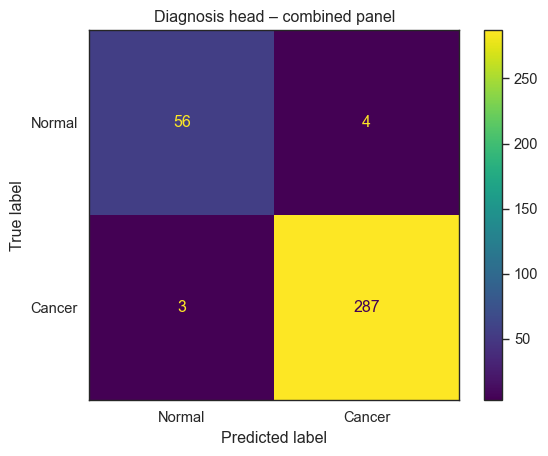


=== Subtype head (combined panel) on TUMOR TEST (PAM50) ===
Tumor test samples with PAM50 (combined panel): 284
              precision    recall  f1-score   support

       Basal     0.9608    0.9245    0.9423        53
        Her2     0.7778    0.7778    0.7778        27
        LumA     0.8852    0.7941    0.8372       136
        LumB     0.6780    0.7143    0.6957        56
      Normal     0.4400    0.9167    0.5946        12

    accuracy                         0.8063       284
   macro avg     0.7484    0.8255    0.7695       284
weighted avg     0.8294    0.8063    0.8130       284


Confusion matrix (rows=true, cols=pred) – subtype head, combined panel:
             pred_Basal  pred_Her2  pred_LumA  pred_LumB  pred_Normal
true_Basal           49          1          0          0            3
true_Her2             1         21          1          2            2
true_LumA             1          3        108         16            8
true_LumB             0          2         13

In [28]:
# New Cell: Train and evaluate MultiHeadVAE on combined gene panel

print("\n--- Training MultiHeadVAE on combined gene panel ---")

combined_vae = MultiHeadVAE(
    original_dim=X_train_comb.shape[1],
    latent_dim=CONFIG["latent_dim"],
    num_subtype_classes=len(subtype_encoder.classes_),
    beta=CONFIG["beta_kl"],
)

combined_vae.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG["learning_rate"], clipnorm=1.0),
    loss={
        "diagnosis_output": "binary_crossentropy",
        "subtype_output": "sparse_categorical_crossentropy",
        "reconstruction_output": None,
    },
    loss_weights={
        "diagnosis_output": CONFIG["weight_diag"],
        "subtype_output": CONFIG["weight_sub"],
        "reconstruction_output": 0.01,
    },
    metrics={
        "diagnosis_output": "accuracy",
        "subtype_output": "accuracy",
    },
)

history_combined = combined_vae.fit(
    X_train_comb,
    {
        "diagnosis_output": y_diag_train,
        "subtype_output": y_sub_train,
        "reconstruction_output": X_train_comb,
    },
    sample_weight=sample_weights_train,  # همان weights قبلی
    validation_data=(
        X_val_comb,
        {
            "diagnosis_output": y_diag_val,
            "subtype_output": y_sub_val,
            "reconstruction_output": X_val_comb,
        },
        sample_weights_val,
    ),
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=15,
            restore_best_weights=True,
            monitor="val_loss",
        )
    ],
    verbose=1,
)

# --- Evaluation: diagnosis head on TEST ---

print("\n=== Diagnosis head (combined panel) on TEST ===")

preds_test_comb = combined_vae.predict(
    X_test_comb,
    batch_size=CONFIG["batch_size"],
    verbose=0,
)

y_diag_proba_comb = preds_test_comb["diagnosis_output"].ravel()
y_diag_pred_comb  = (y_diag_proba_comb >= 0.5).astype(int)

print(classification_report(
    y_diag_test,
    y_diag_pred_comb,
    target_names=["Normal", "Cancer"],
    digits=4,
))

print("AUC-ROC (diagnosis, combined panel):",
      roc_auc_score(y_diag_test, y_diag_proba_comb))

ConfusionMatrixDisplay.from_predictions(
    y_diag_test,
    y_diag_pred_comb,
    display_labels=["Normal", "Cancer"],
)
plt.title("Diagnosis head – combined panel")
plt.show()

# --- Evaluation: subtype head on tumor TEST (PAM50) ---

print("\n=== Subtype head (combined panel) on TUMOR TEST (PAM50) ===")

# Only tumor samples with PAM50 (mask_test==1 and y_diag_test==1)
test_mask_tumor_pam50 = (y_diag_test == 1) & (mask_test == 1)

X_test_comb_tumor = X_test_comb[test_mask_tumor_pam50]
y_sub_test_tumor  = y_sub_test[test_mask_tumor_pam50]

print("Tumor test samples with PAM50 (combined panel):", X_test_comb_tumor.shape[0])

subtype_logits_comb = combined_vae.predict(
    X_test_comb_tumor,
    batch_size=CONFIG["batch_size"],
    verbose=0,
)["subtype_output"]

y_sub_pred_comb = np.argmax(subtype_logits_comb, axis=1)

labels_sub = [i for i, name in enumerate(subtype_encoder.classes_) if name != "NA"]
target_names_sub = [subtype_encoder.classes_[i] for i in labels_sub]

print(
    classification_report(
        y_sub_test_tumor,
        y_sub_pred_comb,
        labels=labels_sub,
        target_names=target_names_sub,
        digits=4,
        zero_division=0,
    )
)

cm_sub_comb = confusion_matrix(
    y_sub_test_tumor,
    y_sub_pred_comb,
    labels=labels_sub,
)

print("\nConfusion matrix (rows=true, cols=pred) – subtype head, combined panel:")
print(pd.DataFrame(
    cm_sub_comb,
    index=[f"true_{n}" for n in target_names_sub],
    columns=[f"pred_{n}" for n in target_names_sub],
))